# Final Assigment EDA
### Arnau Pérez Reverte, 05-01-2026
### Programming and Statistical Databases , MESIO UPC-UB

This assigment will deep dive into the full 2024 Yellow Taxi Trip Records dataset from the TLC.

In [ ]:
import time
from pathlib import Path
from functools import reduce

import requests

import duckdb
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy.stats import lognorm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer

The following script fetches the monthly data directly from the TLC servers in case it is not available as `data/data-{month}.parquet`.

In [2]:
data_dir = Path("data/train")
if not data_dir.is_dir():
    data_dir.mkdir(parents=True, exist_ok=True)
if not any(data_dir.iterdir()):
    session: requests.Session = requests.session()
    for month in range(1, 13):
        print(f"Fetching data for month {month:02d}...")
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-{month:02d}.parquet"  # URL may change due to proxies and stuff. Last checked: 28/12
        res = session.get(url=url)
        res.raise_for_status()
        with open(f"data/train/data-{month:02d}.parquet", "wb") as file:
            file.write(res.content)
        print("\tDone!")
        time.sleep(5)  # Sleep because we are good samaritans

## 1. Data ingestion and EDA

We first prepare the DuckDB database reading the downloaded PARQUET files

In [3]:
rels = [duckdb.read_parquet(f"data/train/data-{month:02d}.parquet") for month in range(1, 13)]
rel = reduce(lambda rel_1, rel_2: rel_1.union(rel_2), rels)

In [4]:
rel.query("t", "SELECT count(*) AS TotalCount FROM t")

┌────────────┐
│ TotalCount │
│   int64    │
├────────────┤
│   41169720 │
└────────────┘

In [5]:
columns = rel.columns
columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

The TLC website describes the columns in the following way ([link](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)):

| Field Name | Description |
|------------|-------------|
| VendorID | A code indicating the TPEP provider that provided the record.<br>1 = Creative Mobile Technologies, LLC<br>2 = Curb Mobility, LLC<br>6 = Myle Technologies Inc<br>7 = Helix |
| tpep_pickup_datetime | The date and time when the meter was engaged. |
| tpep_dropoff_datetime | The date and time when the meter was disengaged. |
| passenger_count | The number of passengers in the vehicle. |
| trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| RatecodeID | The final rate code in effect at the end of the trip.<br>1 = Standard rate<br>2 = JFK<br>3 = Newark<br>4 = Nassau or Westchester<br>5 = Negotiated fare<br>6 = Group ride<br>99 = Null/unknown |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka "store and forward," because the vehicle did not have a connection to the server.<br>Y = store and forward trip<br>N = not a store and forward trip |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged. |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged. |
| payment_type | A numeric code signifying how the passenger paid for the trip.<br>0 = Flex Fare trip<br>1 = Credit card<br>2 = Cash<br>3 = No charge<br>4 = Dispute<br>5 = Unknown<br>6 = Voided trip |
| fare_amount | The time-and-distance fare calculated by the meter. For additional information on the following columns, see https://www.nyc.gov/site/tlc/passengers/taxi-fare.page |
| extra | Miscellaneous extras and surcharges. |
| mta_tax | Tax that is automatically triggered based on the metered rate in use. |
| tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| tolls_amount | Total amount of all tolls paid in trip. |
| improvement_surcharge | Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
| congestion_surcharge | Total amount collected in trip for NYS congestion surcharge. |
| airport_fee | For pick up only at LaGuardia and John F. Kennedy Airports. |
| cbd_congestion_fee | Per-trip charge for MTA's Congestion Relief Zone starting Jan. 5, 2025. |

### 1.1 Missing data

In [6]:
rel.to_df().describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,4.116972e+07,41169720,41169720,37078488.0,4.116972e+07,37078488.0,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,4.116972e+07,3.707849e+07,3.707849e+07
mean,1.764232e+00,2024-07-06 10:01:25.051412,2024-07-06 10:18:53.125903,1.333931,4.976101e+00,2.32215,1.642428e+02,1.634475e+02,1.107259e+00,1.926851e+01,1.385953e+00,4.797774e-01,3.307884e+00,5.615266e-01,9.629934e-01,2.783281e+01,2.232144e+00,1.470060e-01
min,1.000000e+00,2002-12-31 16:46:07,2002-12-31 17:24:07,0.0,0.000000e+00,1.0,1.000000e+00,1.000000e+00,0.000000e+00,-2.261200e+03,-9.250000e+00,-5.000000e-01,-3.000000e+02,-1.406300e+02,-1.000000e+00,-2.265450e+03,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-04-06 20:07:27.500000,2024-04-06 20:23:52,1.0,1.010000e+00,1.0,1.320000e+02,1.130000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.575000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-07-03 23:35:15,2024-07-03 23:50:35,1.0,1.760000e+00,1.0,1.610000e+02,1.620000e+02,1.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.600000e+00,0.000000e+00,1.000000e+00,2.100000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-10-08 17:33:35,2024-10-08 17:53:27.250000,1.0,3.360000e+00,1.0,2.330000e+02,2.340000e+02,1.000000e+00,2.260000e+01,2.500000e+00,5.000000e-01,4.250000e+00,0.000000e+00,1.000000e+00,3.060000e+01,2.500000e+00,0.000000e+00
max,7.000000e+00,2026-06-26 23:53:12,2026-06-27 20:59:10,9.0,3.986086e+05,99.0,2.650000e+02,2.650000e+02,5.000000e+00,3.355444e+05,6.599000e+01,4.130000e+01,9.999900e+02,1.702880e+03,2.000000e+00,3.355509e+05,2.520000e+00,1.750000e+00
std,4.258568e-01,NaN,NaN,0.815824,4.192305e+02,10.928049,6.434069e+01,6.960009e+01,6.515108e-01,7.671984e+01,1.815878e+00,1.301830e-01,4.090523e+00,2.240545e+00,2.550554e-01,7.805359e+01,8.746528e-01,5.020407e-01


In [7]:
rel.to_df().isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          4091232
trip_distance                  0
RatecodeID               4091232
store_and_fwd_flag       4091232
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4091232
Airport_fee              4091232
dtype: int64

We shall first take a look into NAs: we observe that the NA count per column is the exact same value, meaning that for some of the configurations in the taxi device, these metrics (`passenger_count`, `RatecodeID`, `store_and_fwd_flag`, `congestion_surcharge`, `Airport_fee`) were not recorded.

In [8]:
rel.query(
    "t",
    """
    SELECT VendorID,  COUNT(*) AS TotalCount, COUNT(*)/(SELECT COUNT(*) FROM t)*100 AS Percentage 
    FROM t WHERE passenger_count IS NULL GROUP BY VendorID
    """,
)

┌──────────┬────────────┬─────────────────────┐
│ VendorID │ TotalCount │     Percentage      │
│  int32   │   int64    │       double        │
├──────────┼────────────┼─────────────────────┤
│        6 │       2069 │ 0.00502553818680331 │
│        2 │    3224609 │  7.8324773644319166 │
│        1 │     864554 │  2.0999754188272353 │
└──────────┴────────────┴─────────────────────┘

We can see that `VendorID = 1, 2` seem to be the kind of devices which do not record such information. `VendorId = 6` on a smaller amount.

In [9]:
rel.query(
    "t",
    """
    SELECT passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge, Airport_fee 
    FROM t 
    WHERE passenger_count IS NULL AND VendorId = 6
    """,
)

┌─────────────────┬────────────┬────────────────────┬──────────────────────┬─────────────┐
│ passenger_count │ RatecodeID │ store_and_fwd_flag │ congestion_surcharge │ Airport_fee │
│      int64      │   int64    │      varchar       │        double        │   double    │
├─────────────────┼────────────┼────────────────────┼──────────────────────┼─────────────┤
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │
│            NULL │       NULL │ NULL               │                 NULL │        NULL │

We could also check if there is something systematically wrong with these trips: let's check start hour of the day and trip length (in minutes) distribution.

<Axes: >

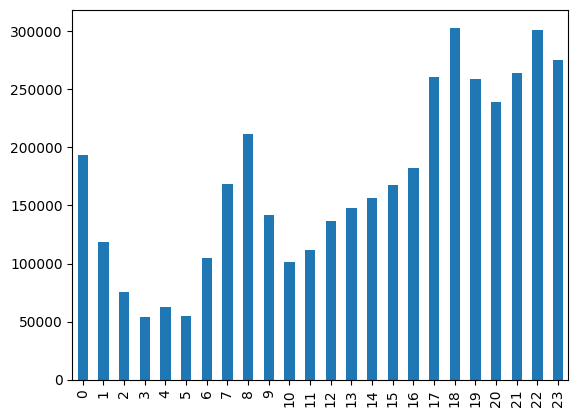

In [10]:
rel.query(
    "t",
    """
    SELECT HOUR(tpep_pickup_datetime) AS PickupStart, COUNT(*) As TotalCount
    FROM t 
    WHERE passenger_count IS NULL
    GROUP BY HOUR(tpep_pickup_datetime) ORDER BY 1
    """,
).to_df().set_index(pd.Series(range(0, 24)))["TotalCount"].plot.bar()

<Axes: >

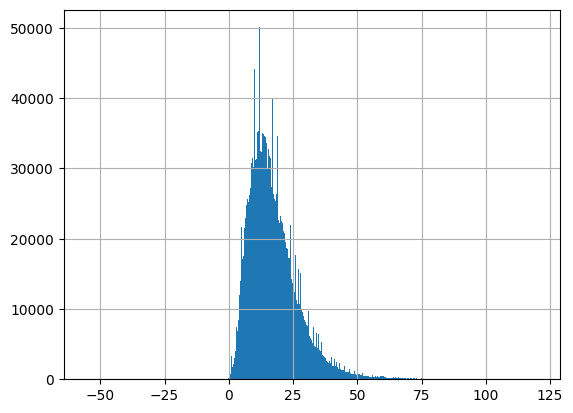

In [11]:
timedelta_df = rel.query(
    "t",
    """
    SELECT tpep_dropoff_datetime - tpep_pickup_datetime AS TripLength
    FROM t 
    WHERE passenger_count IS NULL
    ORDER BY 1
    """,
).to_df()

timedelta_df["TripLength"] = timedelta_df["TripLength"] / np.timedelta64(1, "m")
timedelta_df["TripLength"][timedelta_df["TripLength"] < 120].hist(bins=1000)

In [12]:
timedelta_df.describe()

,TripLength
count,4.091232e+06
mean,1.736438e+01
std,1.238191e+01
min,-5.550000e+01
25%,1.038333e+01
50%,1.540000e+01
75%,2.200000e+01
max,6.622583e+03


We conclude that NAs present in these columns are due to simply lack of information and not a particular event type that we could identify like errors and such. These represent approximately $10 \%$ of the whole sample. Thus, we shall make a decision on what treatment to perform on each specific column (if we were to consider such columns), over these cases:
1. `passenger_count`: This column we may care in future as it contains relevant information. At the same time, if we input data on this field, we would not want to perturbate the original distribution. Hence, we will input sampling from the empirical (marginal) distribution. 
2. `RatecodeId`: This column actually admits an Null/Unknown value (= 99).
3. `store_and_fwd_flag`: This column we don't care so much so we will input with the mode.
4. `congestion_surcharge`: Given that it's a surchage we will either input it to 0 or the mean, once we look at the distribution.
5. `Airport_fee`: We will input the mean fee value if the pickup zone is at either LaGuardia or JFK airports given that is info easily accesible.  

array([[<Axes: title={'center': 'congestion_surcharge'}>]], dtype=object)

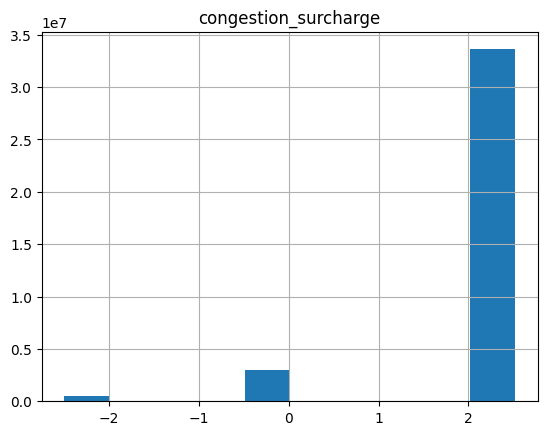

In [13]:
rel.query(
    "f",
    """
    SELECT 
        congestion_surcharge
    FROM t
    WHERE congestion_surcharge IS NOT NULL
    """,
).to_df().hist(bins=10)

In [14]:
rel.query(
    "f",
    """
    SELECT DISTINCT
        congestion_surcharge
    FROM t
    WHERE congestion_surcharge IS NOT NULL
    ORDER BY congestion_surcharge
    """,
).to_df()

,congestion_surcharge
0,-2.50
1,-0.75
2,0.00
3,0.75
4,1.00
5,2.00
6,2.50
7,2.52


Researching the meaning of this column, we find it refers to the NYS Congestion fee which applies to vehicles operating inside a delimited area on the island of Manhattan. We decide to input the mode to not over-complicate this part.

We shall now take a look into the negative values inside payment columns which should be in principle positive. 

In [15]:
def compute_negative_vals(col_name: str):
    return rel.query(
        "t",
        f"""
        SELECT 
            {col_name}_Cases,
            COUNT(*) As TotalCount,
            COUNT(*) / (SELECT COUNT(*) FROM t)*100 AS Percentage 
        FROM(
            SELECT 
                CASE WHEN {col_name} < 0 THEN 'Negative' WHEN {col_name} = 0  THEN 'Zero' ELSE 'Positive' END AS {col_name}_Cases
            FROM t
        )
        GROUP BY  {col_name}_Cases
        ORDER BY 1
        """,
    )

In [16]:
for col in [
    "Airport_fee",
    "congestion_surcharge",
    "total_amount",
    "tolls_amount",
    "fare_amount",
]:
    print(compute_negative_vals(col))

┌───────────────────┬────────────┬─────────────────────┐
│ Airport_fee_Cases │ TotalCount │     Percentage      │
│      varchar      │   int64    │       double        │
├───────────────────┼────────────┼─────────────────────┤
│ Negative          │      99253 │ 0.24108252375775208 │
│ Positive          │    7305212 │  17.744138167565872 │
│ Zero              │   33765255 │   82.01477930867638 │
└───────────────────┴────────────┴─────────────────────┘

┌────────────────────────────┬────────────┬────────────────────┐
│ congestion_surcharge_Cases │ TotalCount │     Percentage     │
│          varchar           │   int64    │       double       │
├────────────────────────────┼────────────┼────────────────────┤
│ Negative                   │     495745 │ 1.2041495545755474 │
│ Positive                   │   37692808 │  91.55468630828678 │
│ Zero                       │    2981167 │  7.241164137137683 │
└────────────────────────────┴────────────┴────────────────────┘

┌────────────────────┬

We observe negative cases to be highly unlikely, so we will input each column with the mean of the zero and positive cases, or the previously defined strategies for `Airport_fee` and `congestion_surcharge` columns.

# 1.2 Exploratory Data Analysis (EDA)

Our EDA will focus on the journey information, characterized by a pick-up Taxi zone location (`PULocationID`) at a given timestamp (`tpep_pickup_datetime`), and the subsequent drop-off at another Taxi zone (`DOLocationID`) at a different time (`tpep_dropoff_datetime`). We will identify journeys following the relation $(\text{PUId}, \text{DOId}) \equiv (\text{DOId}, \text{PUId})$, so that we can understand which Taxi Zones participate the most accross all cominations of journeys.

### 1.2.1 Most visited zones

Up until now, `PULocationId` and `DOLocationId` are primary key identifiers to actual zones in NYC. We retrive the actual dimension tables from the TLC repository.

In [17]:
taxi_file_path = Path("data/zones.csv")
if not taxi_file_path.is_file():
    session: requests.Session = requests.session()
    print("Fetching taxi zone data...")
    url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"  # URL may change due to proxies and stuff. Last checked: 31/12
    res = session.get(url=url)
    res.raise_for_status()
    with open("data/zones.csv", "wb") as file:
        file.write(res.content)
    print("\tDone!")

In [18]:
rel.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [19]:
zones_rel = duckdb.read_csv(taxi_file_path)
zones_rel

┌────────────┬───────────────┬───────────────────────────┬──────────────┐
│ LocationID │    Borough    │           Zone            │ service_zone │
│   int64    │    varchar    │          varchar          │   varchar    │
├────────────┼───────────────┼───────────────────────────┼──────────────┤
│          1 │ EWR           │ Newark Airport            │ EWR          │
│          2 │ Queens        │ Jamaica Bay               │ Boro Zone    │
│          3 │ Bronx         │ Allerton/Pelham Gardens   │ Boro Zone    │
│          4 │ Manhattan     │ Alphabet City             │ Yellow Zone  │
│          5 │ Staten Island │ Arden Heights             │ Boro Zone    │
│          6 │ Staten Island │ Arrochar/Fort Wadsworth   │ Boro Zone    │
│          7 │ Queens        │ Astoria                   │ Boro Zone    │
│          8 │ Queens        │ Astoria Park              │ Boro Zone    │
│          9 │ Queens        │ Auburndale                │ Boro Zone    │
│         10 │ Queens        │ Baisley

We keep `Borough` and `Zone` columns for both pick-up and drop-off columns. 

In [20]:
rel = zones_rel.join(other_rel=rel, condition="LocationID = PULocationID").query(
    "s",
    """
    SELECT
        VendorID,
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        passenger_count,
        trip_distance,
        RatecodeID,
        store_and_fwd_flag,
        PULocationID,
        Borough AS PUBorough,
        Zone AS PUZone,
        DOLocationID,
        payment_type,
        fare_amount,
        extra,
        mta_tax,
        tip_amount,
        tolls_amount,
        improvement_surcharge,
        total_amount,
        congestion_surcharge,
        Airport_fee
    FROM s
    """,
)
rel

┌──────────┬──────────────────────┬───────────────────────┬─────────────────┬───────────────┬────────────┬────────────────────┬──────────────┬───────────┬──────────────────────────┬──────────────┬──────────────┬─────────────┬────────┬─────────┬────────────┬──────────────┬───────────────────────┬──────────────┬──────────────────────┬─────────────┐
│ VendorID │ tpep_pickup_datetime │ tpep_dropoff_datetime │ passenger_count │ trip_distance │ RatecodeID │ store_and_fwd_flag │ PULocationID │ PUBorough │          PUZone          │ DOLocationID │ payment_type │ fare_amount │ extra  │ mta_tax │ tip_amount │ tolls_amount │ improvement_surcharge │ total_amount │ congestion_surcharge │ Airport_fee │
│  int32   │      timestamp       │       timestamp       │      int64      │    double     │   int64    │      varchar       │    int32     │  varchar  │         varchar          │    int32     │    int64     │   double    │ double │ double  │   double   │    double    │        double         │    do

In [21]:
rel = zones_rel.join(other_rel=rel, condition="LocationID = DOLocationID").query(
    "z",
    """
    SELECT
        VendorID,
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        passenger_count,
        trip_distance,
        RatecodeID,
        store_and_fwd_flag,
        PULocationID,
        PUBorough,
        PUZone,
        DOLocationID,
        Borough AS DOBorough,
        Zone AS DOZone,
        payment_type,
        fare_amount,
        extra,
        mta_tax,
        tip_amount,
        tolls_amount,
        improvement_surcharge,
        total_amount,
        congestion_surcharge,
        Airport_fee
    FROM z
    """,
)

Most of our code will rely on the DuckDB Relational API to extract and filter for the relevant information.

The length of our dataset is really large, as is the distribution of taxi zones across the NYC Metropolitan Area; however, we wish to study how all the 2024 Yellow Taxi Trips are distirbuted among the defined zones. It is clear that Manhattan will make up for most of the records, but that is just a hypothesis.

A really insightful way to visualize this is through a Lorenz Curve.

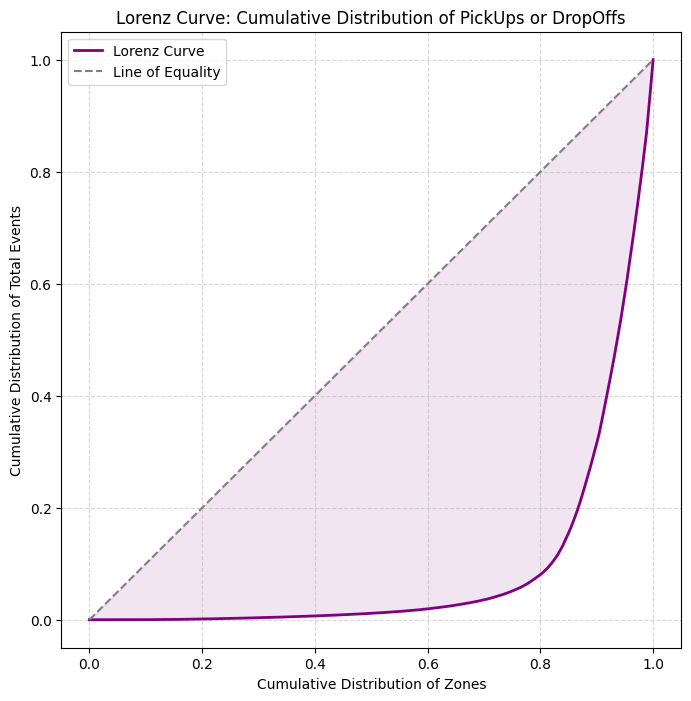

In [22]:
total_events_by_zone = rel.query(
    "u",
    """
    WITH PickUps AS (
         SELECT 
            PUBorough AS Borough,
            PUZone AS Zone,
            COUNT(*) AS PickUps
        FROM u 
        GROUP BY PUBorough, PUZone
    ), DropOffs AS (
        SELECT 
            DOBorough AS Borough,
            DOZone AS Zone,
            COUNT(*) AS DropOffs
        FROM u 
        GROUP BY DOBorough, DOZone
    )
    SELECT 
        p.Borough, p.Zone, p.PickUps, d.DropOffs, p.PickUps +  d.DropOffs as TotalEvents
    FROM PickUps p 
    INNER JOIN DropOffs d ON d.Borough = p.Borough AND d.Zone = p.Zone
    ORDER BY 5 DESC
    """,
)
total_events_by_zone_df = total_events_by_zone.to_df()

sorted_events = total_events_by_zone_df["TotalEvents"].sort_values().values
cumulative_events = np.cumsum(sorted_events)
y_lorenz = np.insert(cumulative_events / cumulative_events[-1], 0, 0)

x_lorenz = np.linspace(0, 1, len(y_lorenz))

plt.figure(figsize=(8, 8))
plt.plot(x_lorenz, y_lorenz, label="Lorenz Curve", color="purple", linewidth=2)

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Line of Equality")

plt.fill_between(x_lorenz, x_lorenz, y_lorenz, color="purple", alpha=0.1)

plt.title("Lorenz Curve: Cumulative Distribution of PickUps or DropOffs")
plt.xlabel("Cumulative Distribution of Zones")
plt.ylabel("Cumulative Distribution of Total Events")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

The more lower right the Lorenz Curve is, the higher the "inequality" of distribution of events (pick-ups or drop-offs) is among all zones, meaning that some zones participate in most journeys.

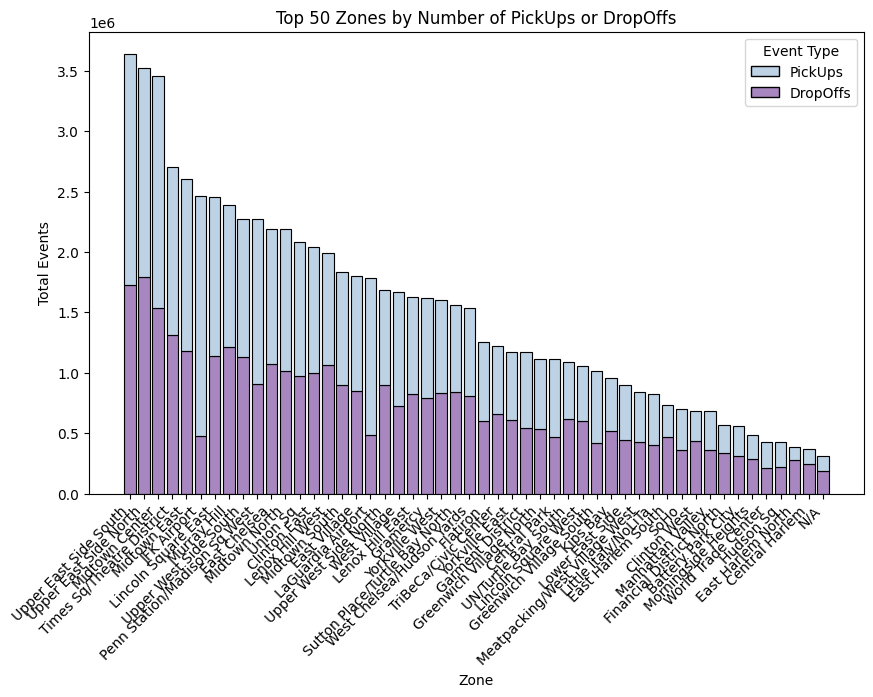

In [23]:
limit = 50
df_melted = total_events_by_zone_df[:limit].melt(
    id_vars="Zone",
    value_vars=["PickUps", "DropOffs"],
    var_name="Event Type",
    value_name="Count",
)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_melted,
    x="Zone",
    weights="Count",
    hue="Event Type",
    multiple="stack",
    palette="BuPu",
    shrink=0.8,
)

plt.xticks(rotation=45, ha="right")
plt.title(f"Top {limit} Zones by Number of PickUps or DropOffs")
plt.ylabel("Total Events")
plt.show()

It is helpful to cut at the $80\%$ of the cumulative distribution of events.

In [24]:
sorted_df = total_events_by_zone_df.sort_values("TotalEvents", ascending=True).copy()
sorted_df["cumulative_events"] = (
    sorted_df["TotalEvents"].cumsum() / sorted_df["TotalEvents"].sum()
)

below_80_df = sorted_df[sorted_df["cumulative_events"] <= 0.8].copy()
above_80_df = sorted_df[sorted_df["cumulative_events"] > 0.8].copy()

In [25]:
above_80_df

,Borough,Zone,PickUps,DropOffs,TotalEvents,cumulative_events
5,Queens,JFK Airport,1989994,476800,2466794,0.806640
4,Manhattan,Midtown East,1418847,1183375,2602222,0.838243
3,Manhattan,Times Sq/Theatre District,1391159,1310990,2702149,0.871060
2,Manhattan,Midtown Center,1914607,1539905,3454512,0.913015
1,Manhattan,Upper East Side North,1729896,1793164,3523060,0.955802
0,Manhattan,Upper East Side South,1915441,1723802,3639243,1.000000


These previous $6$ Taxi zones already account for $20\%$ of all 2024 Yellow Taxi Trips, representing the very heart of NYC taxi traffic. As expected, they belong to Manhattan.

We now investigate, for these taxi zones, how PickUp-DropOff distribution of journeys evolves during the hours of the day.

In [26]:
def event_type_evolution_by_zone(zone_name):
    event_evolution = rel.query(
        "rel3",
        f"""
        WITH DistinctLocations AS (
            SELECT DISTINCT PUZone AS Zone
            FROM rel3
            WHERE Zone = '{zone_name}'
        ), EventTimestamp AS (
            SELECT 
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN d1.Zone
                    WHEN d2.Zone IS NOT NULL THEN d2.Zone
                    ELSE NULL END AS Zone,
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN 'PickUp'
                    WHEN d2.Zone IS NOT NULL THEN 'DropOff'
                    ELSE NULL END AS Event,
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN  tpep_pickup_datetime  
                    WHEN d2.Zone IS NOT NULL THEN  tpep_dropoff_datetime
                    ELSE NULL END AS Time
            FROM rel3
            LEFT JOIN DistinctLocations d1 ON d1.Zone = rel3.PUZone
            LEFT JOIN DistinctLocations d2 ON d2.Zone = rel3.DOZone
            WHERE d1.Zone IS NOT NULL or d2.Zone IS NOT NULL 
        )
        SELECT 
            Zone,
            Event,
            HOUR(Time) as Hour,
            COUNT(*) AS TotalCount
        FROM EventTimestamp
        GROUP BY Zone, Event, HOUR(Time)
        ORDER BY HOUR(Time) ASC
        """,
    )

    sns.histplot(
        data=event_evolution.to_df(),
        x="Hour",
        weights="TotalCount",
        hue="Event",
        multiple="stack",
        palette="BuPu",
        shrink=0.8,
        bins=24,
    )
    plt.title(f"Hourly Evolution: {zone_name}")
    plt.show()

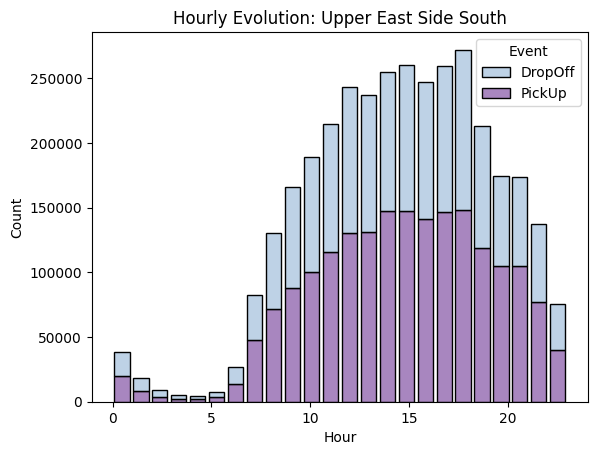

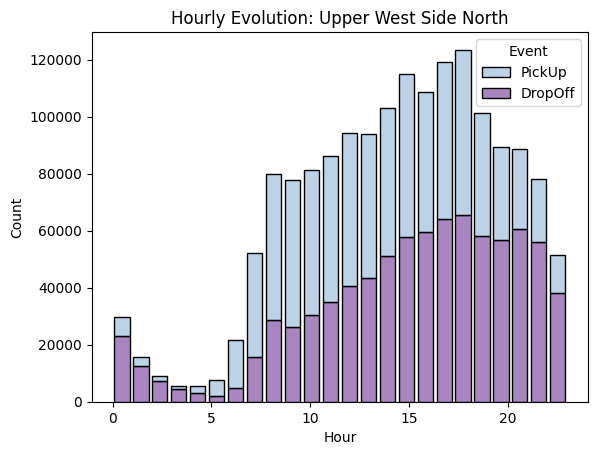

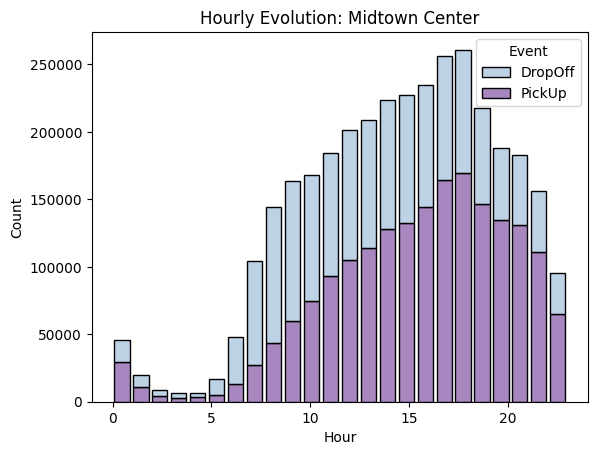

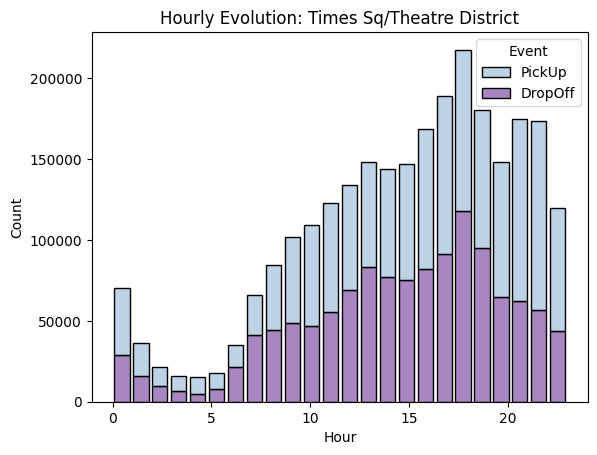

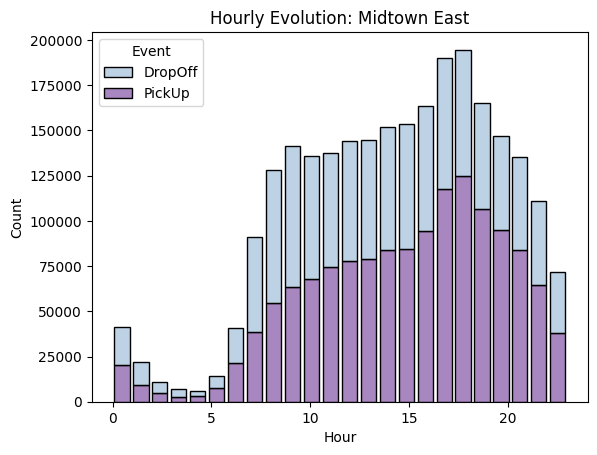

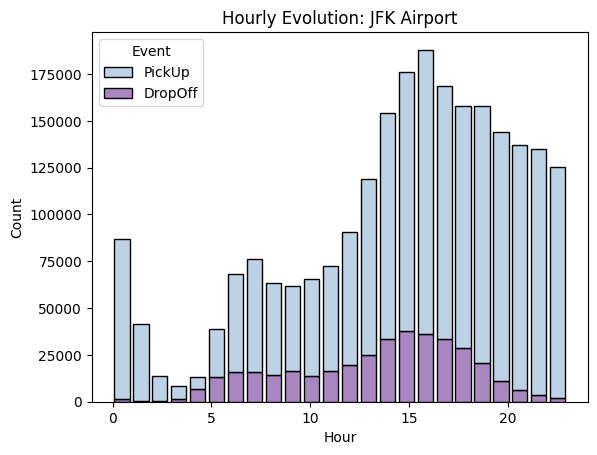

In [27]:
event_type_evolution_by_zone(zone_name="Upper East Side South")
event_type_evolution_by_zone(zone_name="Upper West Side North")
event_type_evolution_by_zone(zone_name="Midtown Center")
event_type_evolution_by_zone(zone_name="Times Sq/Theatre District")
event_type_evolution_by_zone(zone_name="Midtown East")
event_type_evolution_by_zone(zone_name="JFK Airport")

This idea is easier to visualize via the journey Net Flow, $\text{Net Flow} = \text{DropOffs} - \text{PickUps}$.

In [28]:
def net_flow_evolution_by_zone(zone_name):
    event_evolution = rel.query(
        "rel5",
        f"""
        WITH DistinctLocations AS (
            SELECT DISTINCT PUZone AS Zone
            FROM rel5
            WHERE Zone = '{zone_name}'
        ), EventTimestamp AS (
            SELECT 
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN d1.Zone
                    WHEN d2.Zone IS NOT NULL THEN d2.Zone
                    ELSE NULL END AS Zone,
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN 'PickUp'
                    WHEN d2.Zone IS NOT NULL THEN 'DropOff'
                    ELSE NULL END AS Event,
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN  tpep_pickup_datetime  
                    WHEN d2.Zone IS NOT NULL THEN  tpep_dropoff_datetime
                    ELSE NULL END AS Time
            FROM rel5
            LEFT JOIN DistinctLocations d1 ON d1.Zone = rel5.PUZone
            LEFT JOIN DistinctLocations d2 ON d2.Zone = rel5.DOZone
            WHERE d1.Zone IS NOT NULL or d2.Zone IS NOT NULL 
        ), HourlyEventCount AS (
            SELECT 
                Zone,
                Event,
                HOUR(Time) as Hour,
                COUNT(*) AS TotalCount
            FROM EventTimestamp
            GROUP BY Zone, Event, HOUR(Time)
        ) 
        SELECT 
            h1.Zone,
            h1.Hour,
            h1.TotalCount AS CountPickUps,
            h2.TotalCount AS CountDropOffs,
            h2.TotalCount - h1.TotalCount AS NetFlow
        FROM HourlyEventCount h1
        INNER JOIN HourlyEventCount h2 ON h1.Zone = h2.Zone AND h1.Hour = h2.Hour
        WHERE h1.Event = 'PickUp' AND h2.Event = 'DropOff'
        ORDER BY 1 ASC, 2 ASC 
        """,
    )

    df = event_evolution.to_df()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df, x="Hour", y="NetFlow", ax=ax, marker="o", color="purple")

    ax.axhline(0, color="black", linestyle="--", linewidth=1)

    lim = np.max(np.abs(df["NetFlow"])) * 1.1
    ax.set_ylim(-lim, lim)
    ax.set_title(f"Hourly Net Flow Evolution: {zone_name}")
    ax.set_xlabel("Hour of Day (0-23)")
    ax.set_ylabel("Net Flow (DropOffs - PickUps)")

    ax.set_xticks(range(0, 24, 2))

    plt.grid(True, alpha=0.3)
    plt.show()

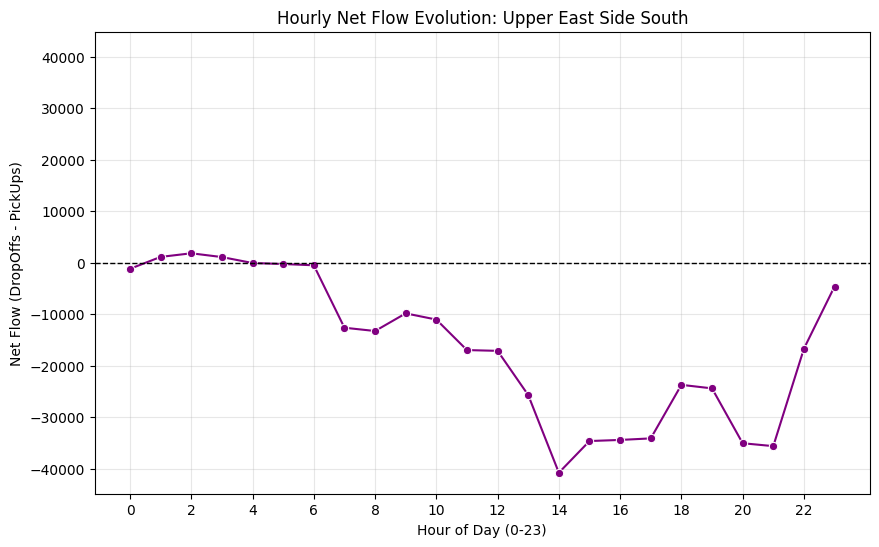

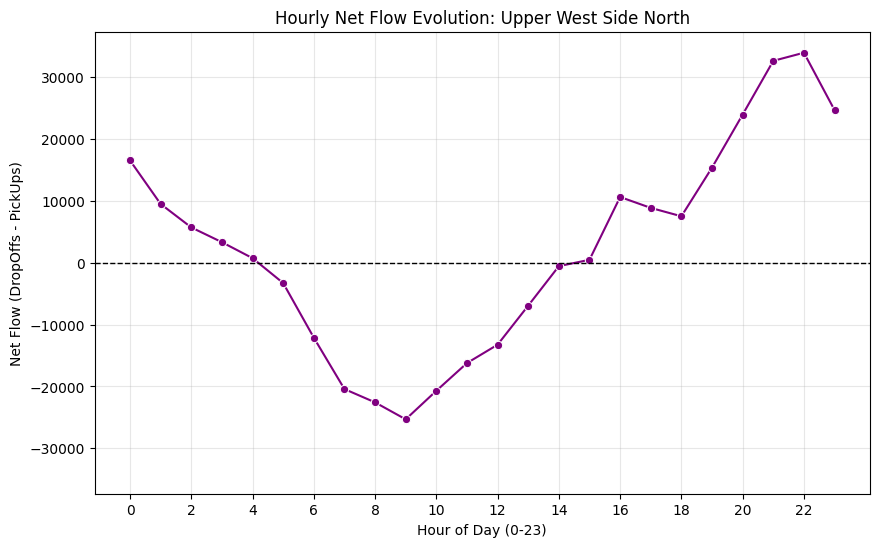

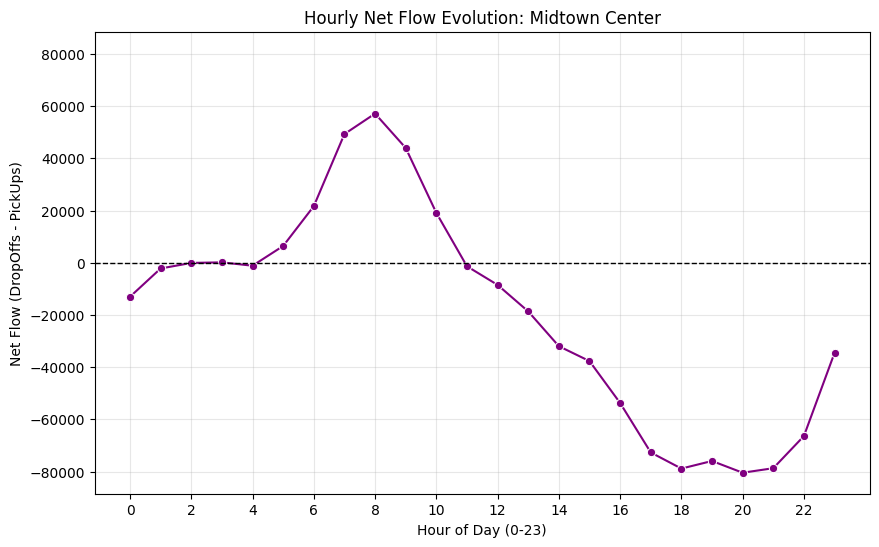

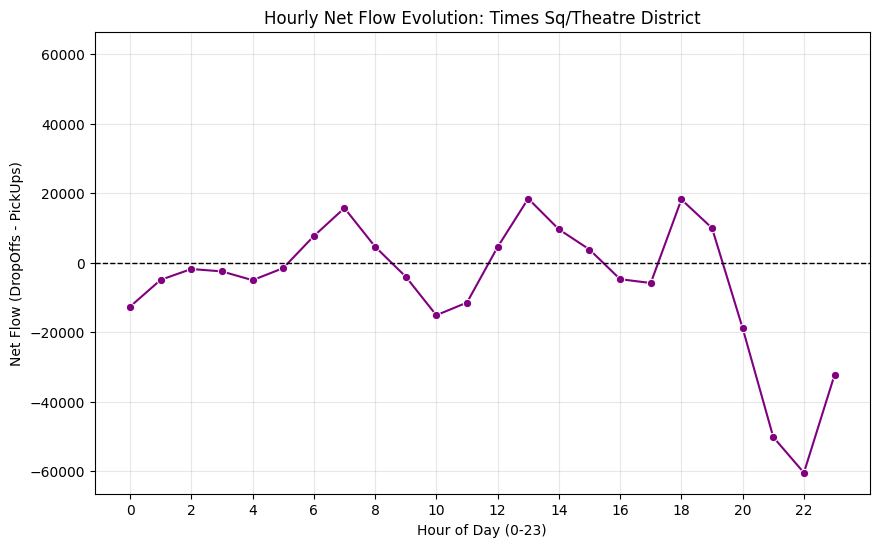

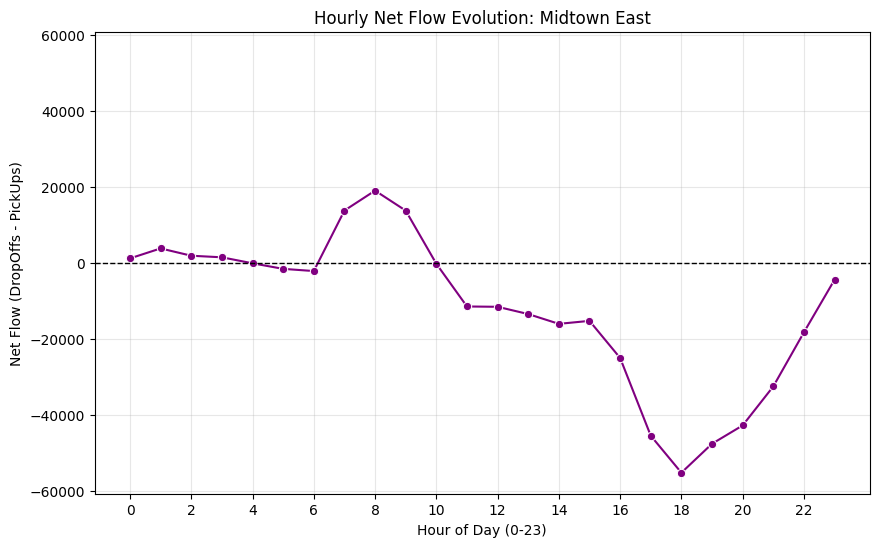

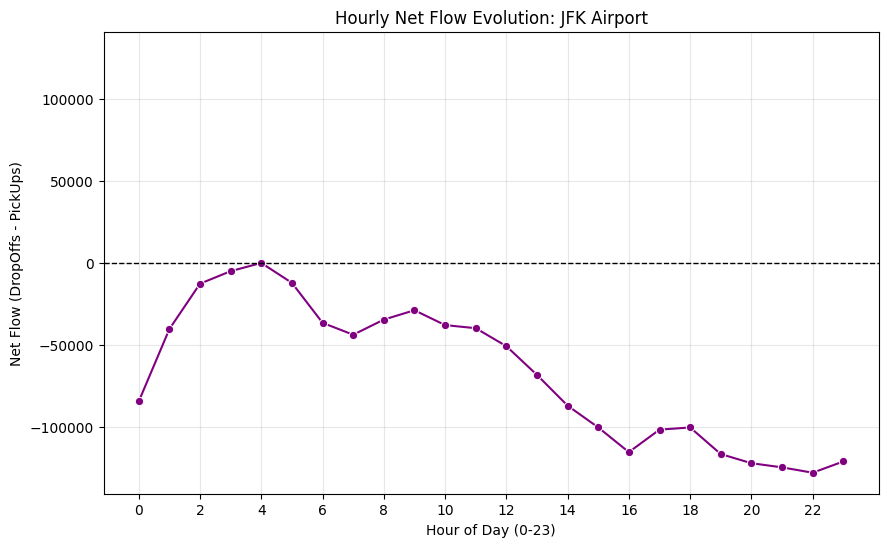

In [29]:
net_flow_evolution_by_zone(zone_name="Upper East Side South")
net_flow_evolution_by_zone(zone_name="Upper West Side North")
net_flow_evolution_by_zone(zone_name="Midtown Center")
net_flow_evolution_by_zone(zone_name="Times Sq/Theatre District")
net_flow_evolution_by_zone(zone_name="Midtown East")
net_flow_evolution_by_zone(zone_name="JFK Airport")

Observe how the nature of each zone is distinct, and different from the others. During certain hours of the day zone can become predominately pick-up zones and later evolve into drop-offs (observe Upper West Side North, for instance). Given the fact that this zones account for $20\%$ of the trips, there must exist a dynamic (difficult-to-observe) correlation between the metric of one of these zones with another, as they essentially distribute most of Yellow taxis cabs between one another.

### 1.2.2 Most frequent routes

Let's look in particular which routes are the most performed. Remember that we identified $(\text{PUId}, \text{DOId}) \equiv (\text{DOId}, \text{PUId})$:

In [30]:
trip_pairs = rel.query(
    "rel",
    """
    WITH DistinctLocations AS (
        SELECT DISTINCT PUZone AS Zone
        FROM rel
    )
    SELECT 
        d1.Zone AS Origin,
        d2.Zone AS Destination
    FROM DistinctLocations d1
    CROSS JOIN DistinctLocations d2 
    WHERE d1.Zone < d2.Zone
    """,
)
trip_pairs

┌─────────────────────────┬───────────────────────────┐
│         Origin          │        Destination        │
│         varchar         │          varchar          │
├─────────────────────────┼───────────────────────────┤
│ Arden Heights           │ Arrochar/Fort Wadsworth   │
│ Arden Heights           │ Astoria                   │
│ Arrochar/Fort Wadsworth │ Astoria                   │
│ Arden Heights           │ Astoria Park              │
│ Arrochar/Fort Wadsworth │ Astoria Park              │
│ Arden Heights           │ Auburndale                │
│ Arrochar/Fort Wadsworth │ Auburndale                │
│ Arden Heights           │ Baisley Park              │
│ Arrochar/Fort Wadsworth │ Baisley Park              │
│ Arden Heights           │ Bath Beach                │
│     ·                   │     ·                     │
│     ·                   │     ·                     │
│     ·                   │     ·                     │
│ Stapleton               │ Times Sq/Theatre Dis

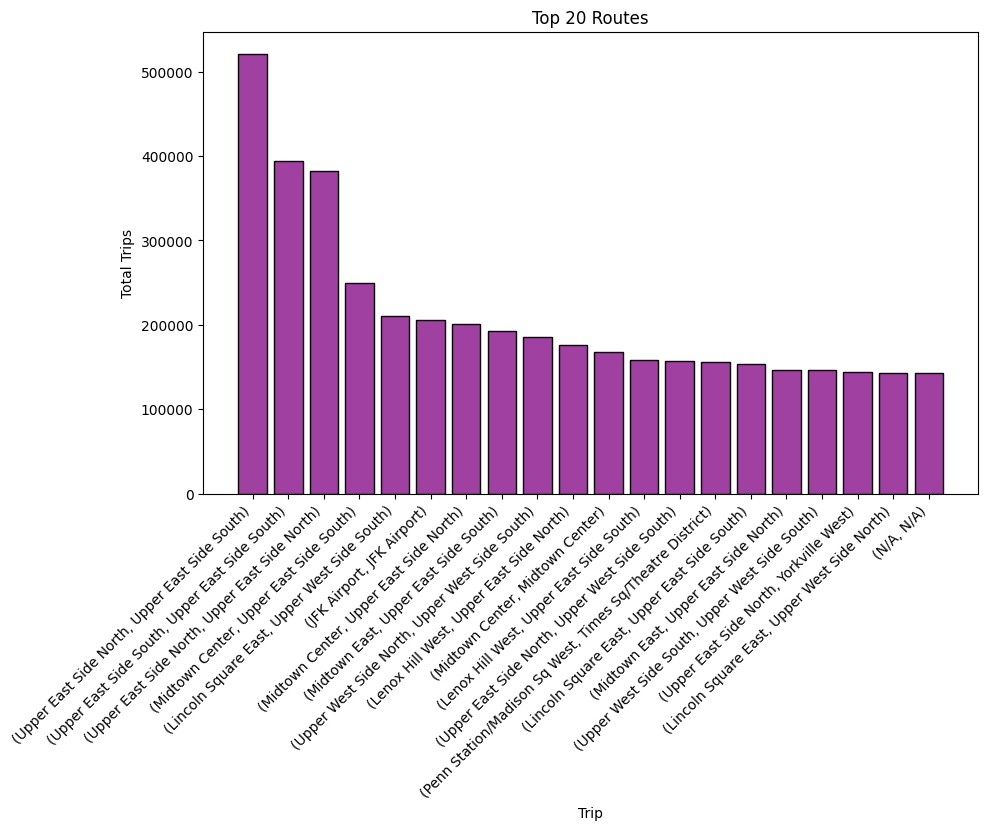

In [31]:
total_trip_count = rel.query(
    "rel1",
    """
    WITH DistinctLocations AS (
        SELECT DISTINCT PUZone AS Zone
        FROM rel1
    ), 
    UniqueTrips AS (
        SELECT d1.Zone AS Origin, d2.Zone AS Destination
        FROM DistinctLocations d1 
        CROSS JOIN DistinctLocations d2 
        WHERE d1.Zone <= d2.Zone 
    ) 
    SELECT 
        CONCAT('(', Origin, ', ', Destination, ')') AS Trip,
        COUNT(*) AS TotalCount
    FROM 
    (
        SELECT 
            u.Origin,       
            u.Destination
        FROM rel1
        INNER JOIN UniqueTrips u 
        ON u.Origin = rel1.PUZone AND u.Destination = rel1.DOZone

        UNION ALL

        SELECT 
            u.Origin,     
            u.Destination
        FROM rel1
        INNER JOIN UniqueTrips u 
        ON u.Origin = rel1.DOZone AND u.Destination = rel1.PUZone
    )
    GROUP BY Origin, Destination
    ORDER BY 2 DESC
    """,
)

limit = 20
df_trip_count = total_trip_count.to_df()
df_trip_count_limit = df_trip_count[:limit]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_trip_count_limit, x="Trip", weights="TotalCount", color="purple", shrink=0.8
)

plt.xticks(rotation=45, ha="right")
plt.title(f"Top {limit} Routes")
plt.ylabel("Total Trips")
plt.show()

The $6$ zones we characterized previously, we clearly observe them here again, participating in the most common routes. We can actually look at the top $20%$ aswell:

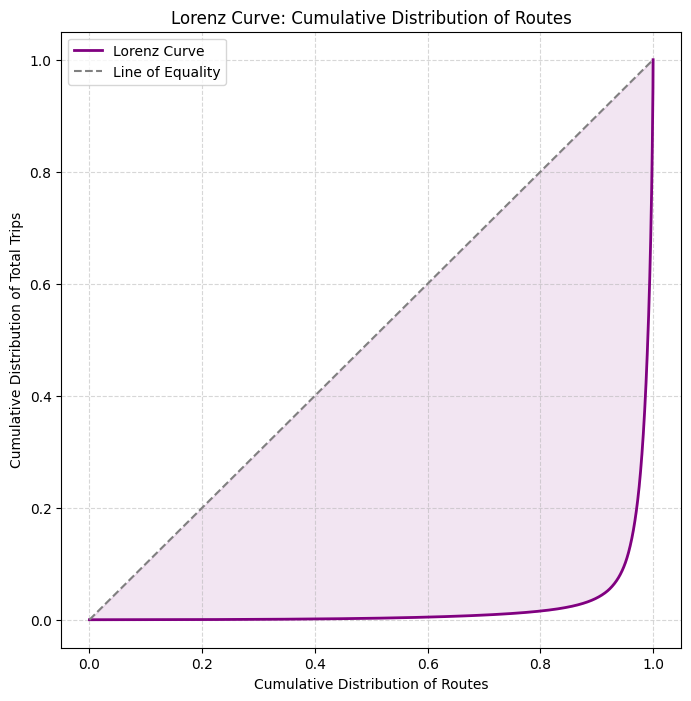

In [32]:
sorted_events = df_trip_count["TotalCount"].sort_values().values
cumulative_events = np.cumsum(sorted_events)
y_lorenz = np.insert(cumulative_events / cumulative_events[-1], 0, 0)


x_lorenz = np.linspace(0, 1, len(y_lorenz))

plt.figure(figsize=(8, 8))
plt.plot(x_lorenz, y_lorenz, label="Lorenz Curve", color="purple", linewidth=2)

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Line of Equality")

plt.fill_between(x_lorenz, x_lorenz, y_lorenz, color="purple", alpha=0.1)

plt.title("Lorenz Curve: Cumulative Distribution of Routes")
plt.xlabel("Cumulative Distribution of Routes")
plt.ylabel("Cumulative Distribution of Total Trips")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [33]:
sorted_df = df_trip_count.sort_values("TotalCount", ascending=True).copy()
sorted_df["cumulative_events"] = (
    sorted_df["TotalCount"].cumsum() / sorted_df["TotalCount"].sum()
)

below_80_df = sorted_df[sorted_df["cumulative_events"] <= 0.8].copy()
above_80_df = sorted_df[sorted_df["cumulative_events"] > 0.8].copy()

In [34]:
above_80_df

,Trip,TotalCount,cumulative_events
56,"(Upper West Side North, Upper West Side North)",103142,0.801034
55,"(East Chelsea, Times Sq/Theatre District)",103551,0.803426
54,"(Lincoln Square East, Midtown North)",106749,0.805892
53,"(Lincoln Square East, Times Sq/Theatre District)",106820,0.808359
52,"(Lenox Hill West, Midtown East)",106840,0.810827
51,"(Murray Hill, Penn Station/Madison Sq West)",107024,0.813299
50,"(East Village, East Village)",107064,0.815772
49,"(Midtown East, Midtown East)",107414,0.818253
48,"(Clinton East, Lincoln Square East)",109433,0.820781
47,"(Sutton Place/Turtle Bay North, Upper East Sid...",111263,0.823351


### 1.2.3 Trip Duration

We proceed to investigate the distribution of the (time) trip duration of each zone, easily obtained by subtracting pick-up timestamp from the drop-off.

In [35]:
def trip_duration_by_zone(zone_name: str):
    trip_duration_dist = rel.query(
        "rel4",
        f"""
            WITH DistinctLocations AS (
                SELECT DISTINCT PUZone AS Zone
                FROM rel4
                WHERE Zone = '{zone_name}'
            )
            SELECT 
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN d1.Zone
                    WHEN d2.Zone IS NOT NULL THEN d2.Zone
                    ELSE NULL END AS Zone,
                    tpep_dropoff_datetime - tpep_pickup_datetime AS TripDuration
            FROM rel4
            LEFT JOIN DistinctLocations d1 ON d1.Zone = rel4.PUZone
            LEFT JOIN DistinctLocations d2 ON d2.Zone = rel4.DOZone
            WHERE d1.Zone IS NOT NULL or d2.Zone IS NOT NULL 
            ORDER BY TripDuration ASC
            """,
    )
    trip_duration_dist_df = trip_duration_dist.to_df()

    trip_duration_dist_df["TripDuration"] = trip_duration_dist_df[
        "TripDuration"
    ] / np.timedelta64(1, "m")

    filtered_df = trip_duration_dist_df[
        (trip_duration_dist_df["TripDuration"] < 100)
        & (trip_duration_dist_df["TripDuration"] > 0)
    ]

    mean_val = np.mean(filtered_df["TripDuration"])

    plt.figure(figsize=(10, 6))
    sns.histplot(data=filtered_df, x="TripDuration", color="purple", alpha=0.6)

    plt.axvline(
        x=mean_val,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_val:.2f} min",
    )

    plt.title(f"Trip Duration Distribution: {zone_name}")
    plt.xlabel("Trip Duration (minutes)")

    plt.legend()
    plt.show()

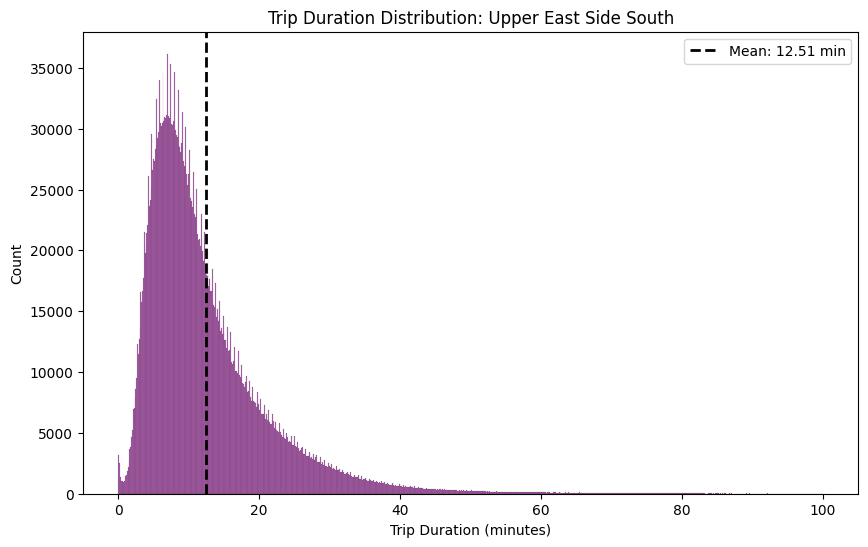

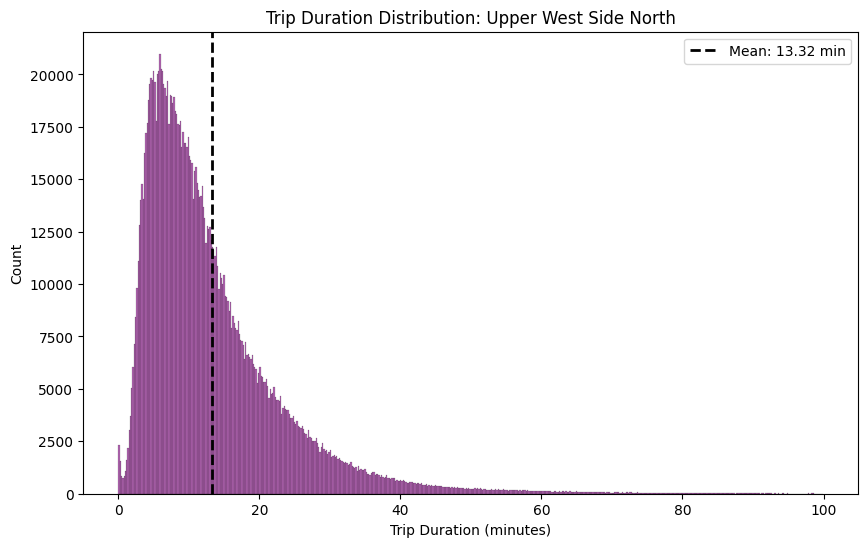

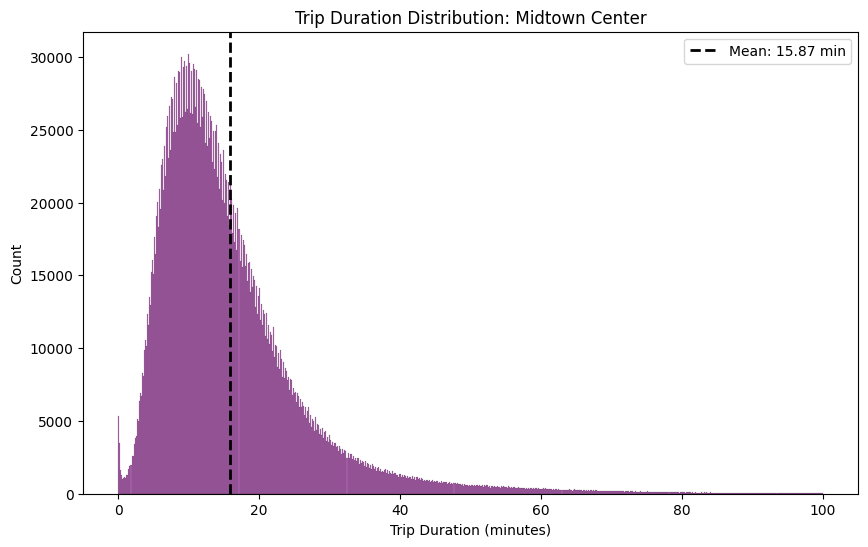

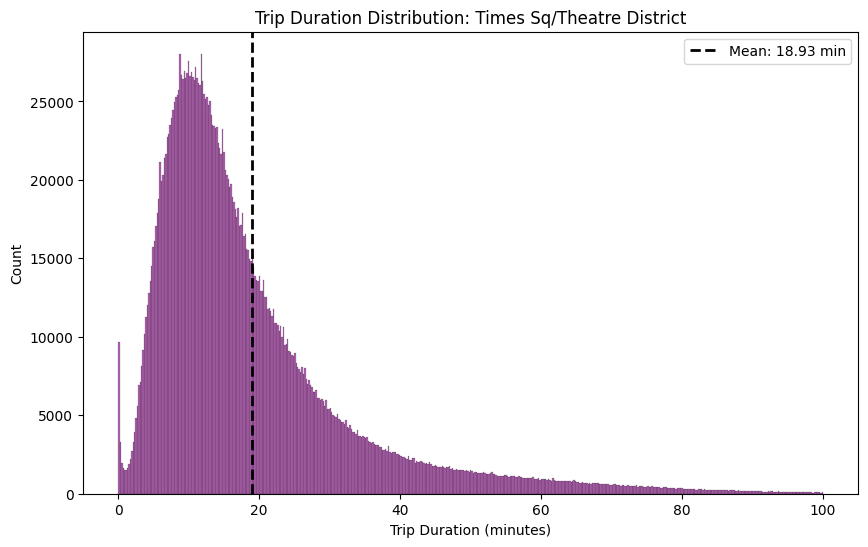

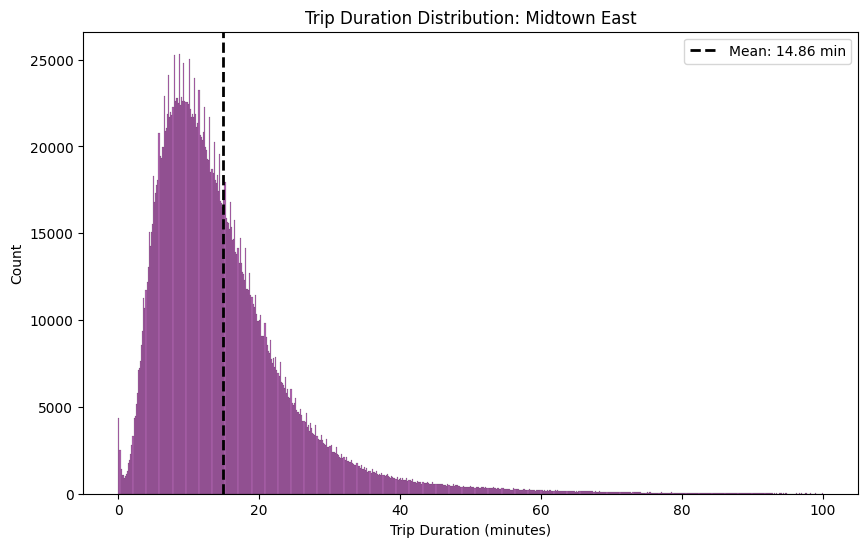

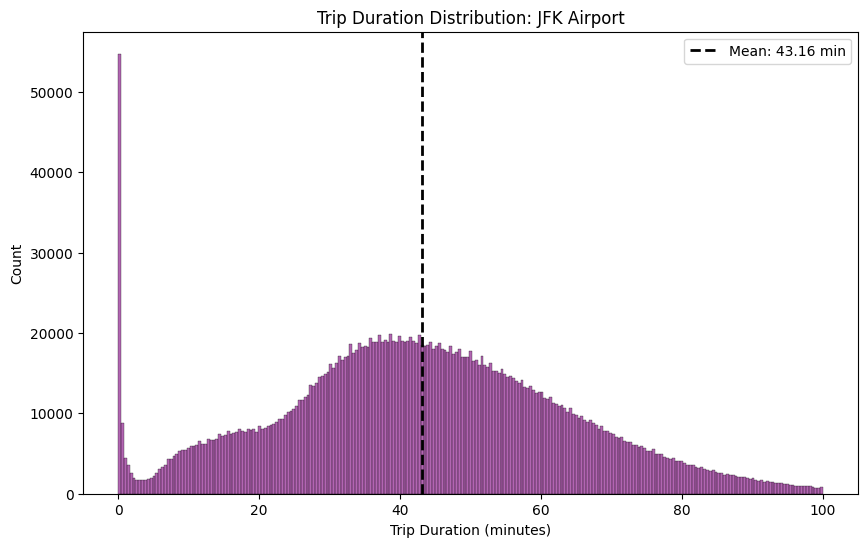

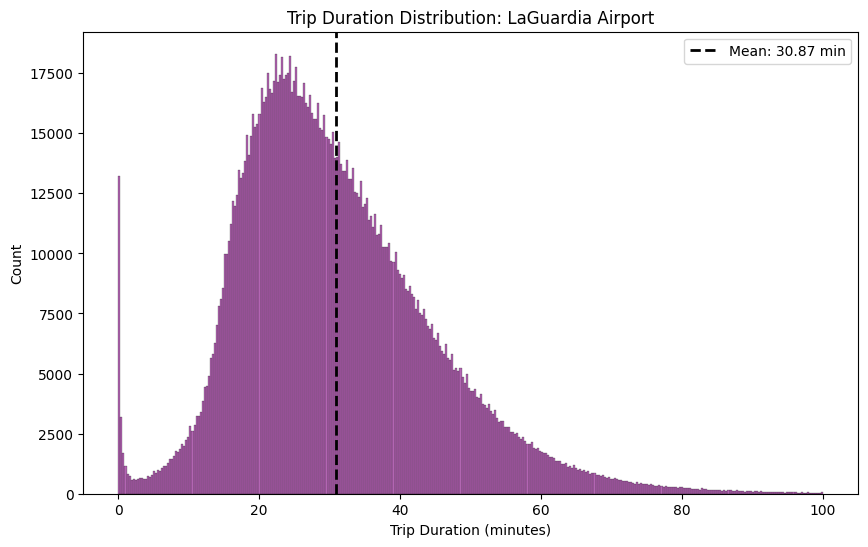

In [36]:
trip_duration_by_zone("Upper East Side South")
trip_duration_by_zone("Upper West Side North")
trip_duration_by_zone("Midtown Center")
trip_duration_by_zone("Times Sq/Theatre District")
trip_duration_by_zone("Midtown East")

trip_duration_by_zone("JFK Airport")
trip_duration_by_zone("LaGuardia Airport")

We observe that for really large sample sizes, these distributions are really well defined, and have a very distinct shape, except for the JFK and LaGuardia airports. Notice that the data used contains the cases $(\text{PUZone}, \text{PUZone})$. Indeed, each distribution is characterized by a rather small bump close to the $0 \text{ min}$, indicating short journeys most probably between the same zone, and an unimodal right-skewed curve which contains the actual trip duration from the zone to another or viceversa, with a very similar mean value ($\approx 15 \text{ min}$). 

The airport trips distributions, however, are characterized by a significantly larger mean value, despite a higher bump at 0. Indeed, this could well be explained by the fact that these airports contain large terminals whose's users prefer to naviagate to, or interchange, via taxi, often resulting in small journeys. The higher mean value is due to the location of the JFK and LaGuardian in Brooklyn and Queens, respectively, which are rather away from Manhattan; hence, the rest of the curve can be identified with the trips from/to the airport to different zones.

For the first case discussed, we can restrict our data to non-same zone trips and try to find a parametric fit to the distinct curve observed. Zhang et al., 2016 [1] propose the lognormal distribution as the best-fitting family of distributions for this phenomenon. This explained by the fact that travel time is affected by traffic, which is in turn a product of multiple effects like distance, weather, congestion, etc.


[1] L. Zhang, S. Luo, and H. Xia, “An Investigation of Intra-Urban Mobility Pattern of Taxi Passengers,” Dec. 26, 2016, arXiv: arXiv:1612.08378. doi: 10.48550/arXiv.1612.08378.


In [37]:
def lognormal_trip_duration_by_zone(zone_name: str):
    trip_duration_dist = rel.query(
        "rel4",
        f"""
            WITH DistinctLocations AS (
                SELECT DISTINCT PUZone AS Zone
                FROM rel4
                WHERE Zone = '{zone_name}'
            )
            SELECT 
                CASE 
                    WHEN d1.Zone IS NOT NULL THEN d1.Zone
                    WHEN d2.Zone IS NOT NULL THEN d2.Zone
                    ELSE NULL END AS Zone,
                    tpep_dropoff_datetime - tpep_pickup_datetime AS TripDuration
            FROM rel4
            LEFT JOIN DistinctLocations d1 ON d1.Zone = rel4.PUZone
            LEFT JOIN DistinctLocations d2 ON d2.Zone = rel4.DOZone
            WHERE (d1.Zone IS NOT NULL OR d2.Zone IS NOT NULL) AND NOT (d1.Zone IS NOT NULL AND d2.Zone IS NOT NULL)
            ORDER BY TripDuration ASC
            """,
    )
    trip_duration_dist_df = trip_duration_dist.to_df()

    trip_duration_dist_df["TripDuration"] = trip_duration_dist_df[
        "TripDuration"
    ] / np.timedelta64(1, "m")

    plot_data = trip_duration_dist_df[
        (trip_duration_dist_df["TripDuration"] < 100)
        & (trip_duration_dist_df["TripDuration"] > 0)
    ]["TripDuration"]

    shape, loc, scale = lognorm.fit(plot_data, floc=0)

    plt.figure(figsize=(10, 6))

    sns.histplot(
        x=plot_data,
        stat="density",
        color="purple",
        alpha=0.4,
        label="Observed Data",
        element="step",
    )

    x_theoretical = np.linspace(0, 100, 1000)
    y_theoretical = lognorm.pdf(x_theoretical, shape, loc, scale)

    plt.plot(
        x_theoretical,
        y_theoretical,
        color="orange",
        lw=2.5,
        linestyle="--",
        label=f"Log-Normal (s={shape:.2f}, scale={scale:.1f})",
    )

    plt.title(f"Trip Duration Distribution: {zone_name} vs. Log-Normal")
    plt.xlabel("Trip Duration (Minutes)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

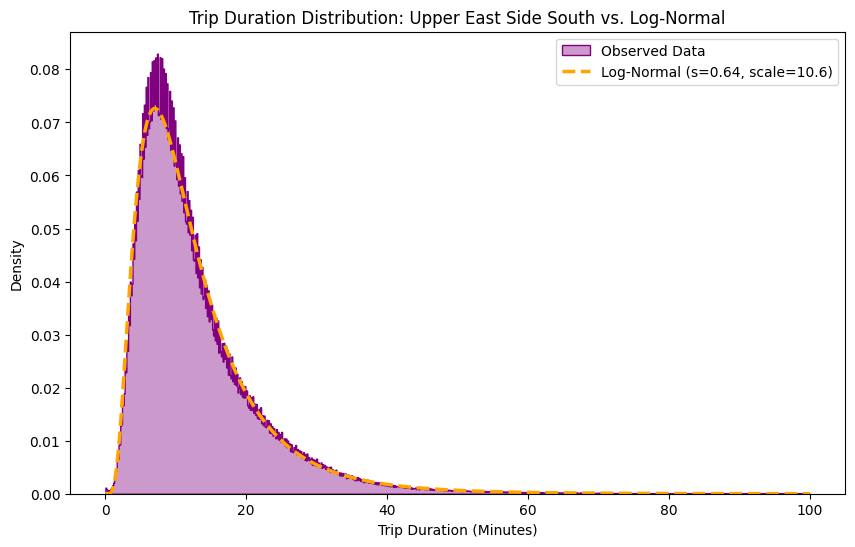

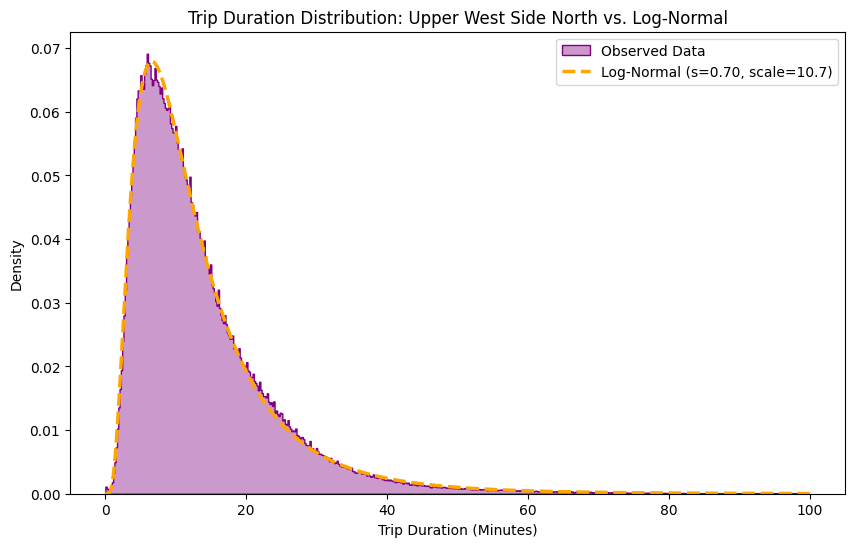

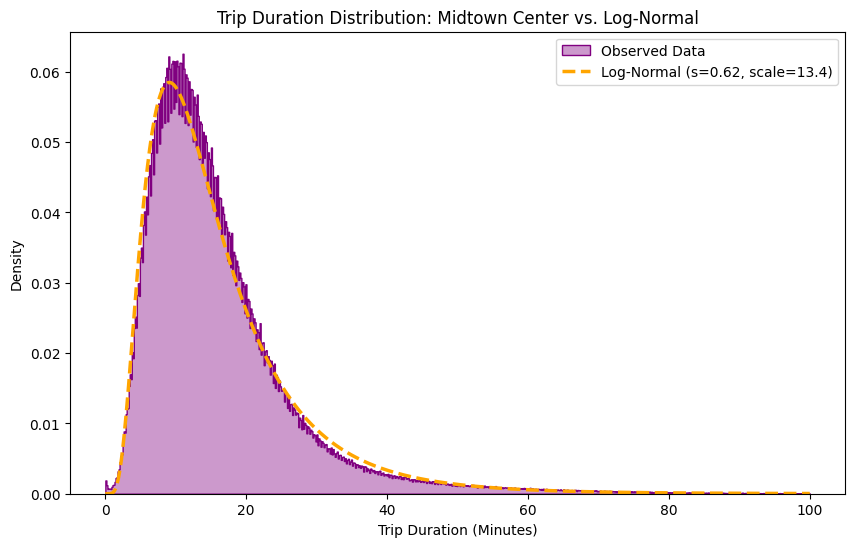

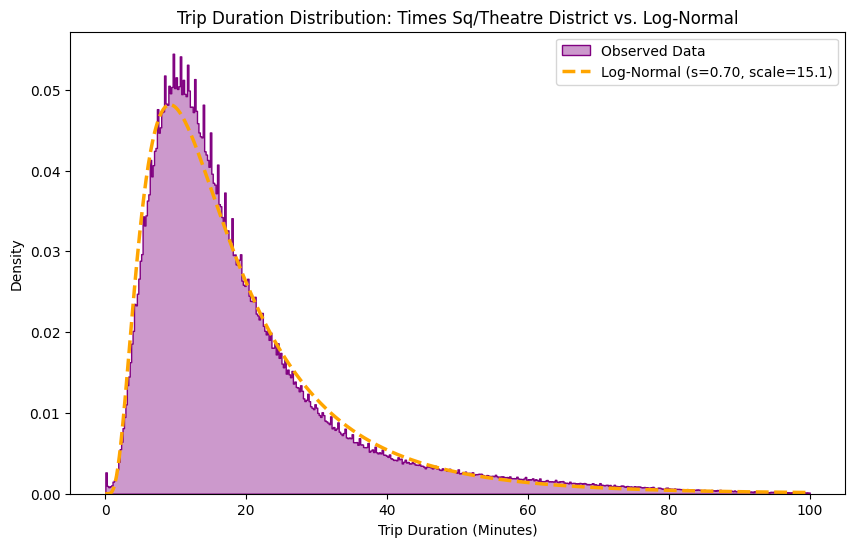

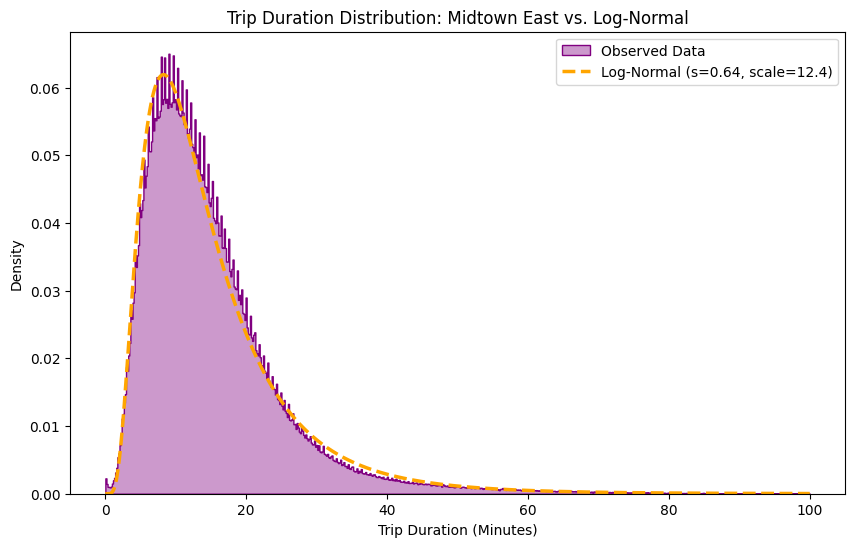

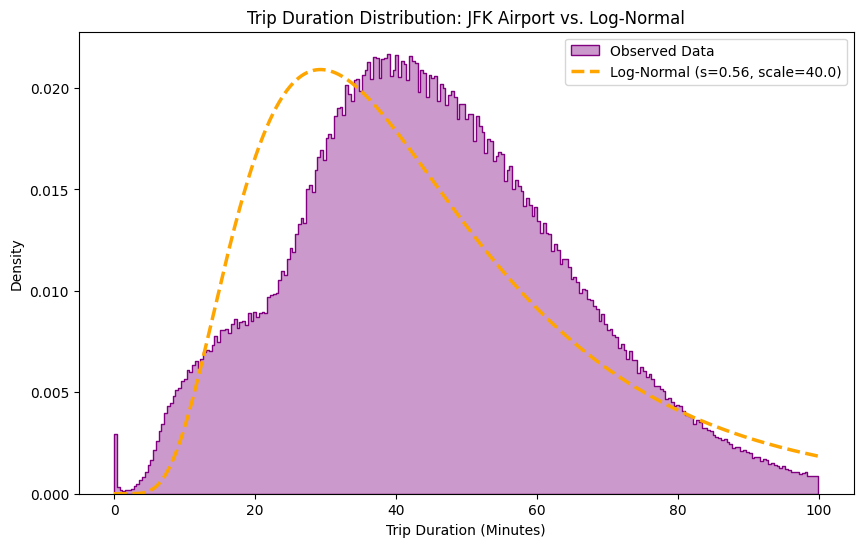

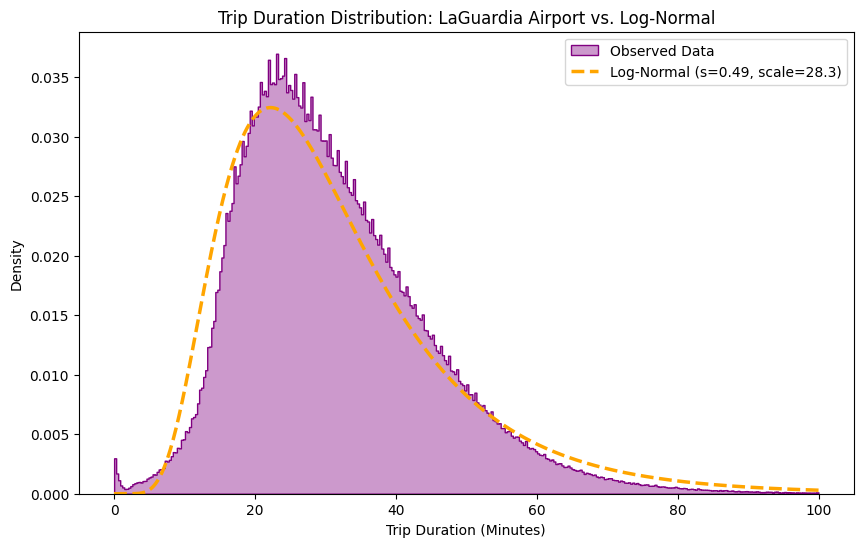

In [38]:
lognormal_trip_duration_by_zone("Upper East Side South")
lognormal_trip_duration_by_zone("Upper West Side North")
lognormal_trip_duration_by_zone("Midtown Center")
lognormal_trip_duration_by_zone("Times Sq/Theatre District")
lognormal_trip_duration_by_zone("Midtown East")

lognormal_trip_duration_by_zone("JFK Airport")
lognormal_trip_duration_by_zone("LaGuardia Airport")

### 1.2.4 Same zone trips 

We finally look at trips within the same zone.

In [39]:
same_zone_trips = rel.query(
    "rel6",
    """
            WITH DistinctLocations AS (
                SELECT DISTINCT PUZone AS Zone
                FROM rel6
            )
            SELECT 
                d1.Zone AS Zone,
                COUNT(*) AS TotalCount
            FROM rel6
            INNER JOIN DistinctLocations d1 ON d1.Zone = rel6.PUZone
            INNER JOIN DistinctLocations d2 ON d2.Zone = rel6.DOZone
            WHERE d1.Zone = d2.Zone 
            GROUP BY d1.Zone
            ORDER BY 2 DESC
            """,
)
same_zone_trips

┌───────────────────────┬────────────┐
│         Zone          │ TotalCount │
│        varchar        │   int64    │
├───────────────────────┼────────────┤
│ Upper East Side South │     196947 │
│ Upper East Side North │     191380 │
│ JFK Airport           │     102841 │
│ Midtown Center        │      83673 │
│ Upper West Side South │      73346 │
│ N/A                   │      71174 │
│ Lincoln Square East   │      63645 │
│ East Chelsea          │      61624 │
│ Clinton East          │      61607 │
│ Lenox Hill West       │      61147 │
│       ·               │          · │
│       ·               │          · │
│       ·               │          · │
│ West Brighton         │         10 │
│ Port Richmond         │         10 │
│ Green-Wood Cemetery   │          7 │
│ Pelham Bay Park       │          6 │
│ Country Club          │          6 │
│ Oakwood               │          5 │
│ Arden Heights         │          5 │
│ Crotona Park          │          5 │
│ Broad Channel         │

In [40]:
def trip_duration_same_zone(zone_name: str):
    trip_duration_dist = rel.query(
        "rel4",
        f"""
            WITH DistinctLocations AS (
                SELECT DISTINCT PUZone AS Zone
                FROM rel4
                WHERE Zone = '{zone_name}'
            )
            SELECT 
                d1.Zone AS Zone,
                tpep_dropoff_datetime - tpep_pickup_datetime AS TripDuration
            FROM rel4
            LEFT JOIN DistinctLocations d1 ON d1.Zone = rel4.PUZone
            LEFT JOIN DistinctLocations d2 ON d2.Zone = rel4.DOZone
            WHERE (d1.Zone IS NOT NULL AND d2.Zone IS NOT NULL)
            ORDER BY TripDuration ASC
            """,
    )
    trip_duration_dist_df = trip_duration_dist.to_df()

    trip_duration_dist_df["TripDuration"] = trip_duration_dist_df[
        "TripDuration"
    ] / np.timedelta64(1, "m")

    plot_data = trip_duration_dist_df[
        (trip_duration_dist_df["TripDuration"] < 25)
        & (trip_duration_dist_df["TripDuration"] > 0)
    ]["TripDuration"]

    plt.figure(figsize=(10, 6))
    sns.histplot(
        x=plot_data,
        color="purple",
        element="step",
    )

    plt.title(f"Trip Duration Distribution: {zone_name}")
    plt.xlabel("Trip Duration (Minutes)")
    plt.ylabel("Count")
    plt.show()

We can also take a look into their trip durations.

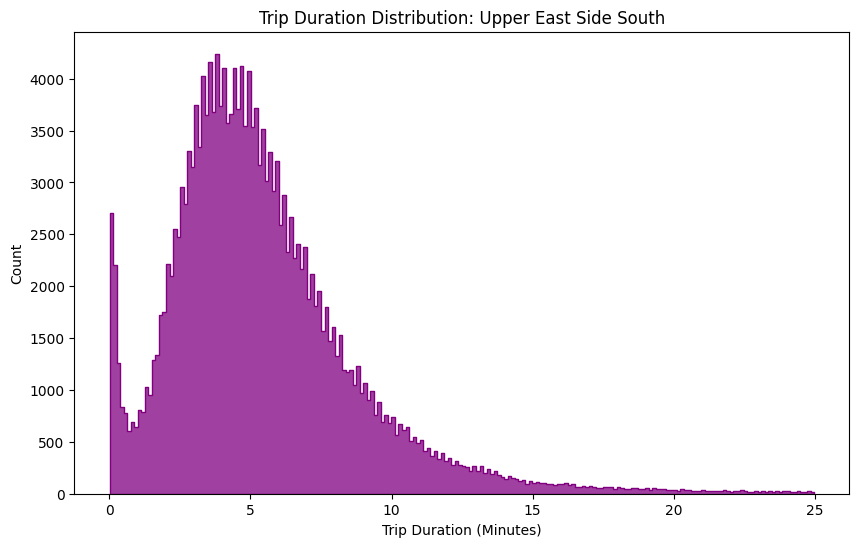

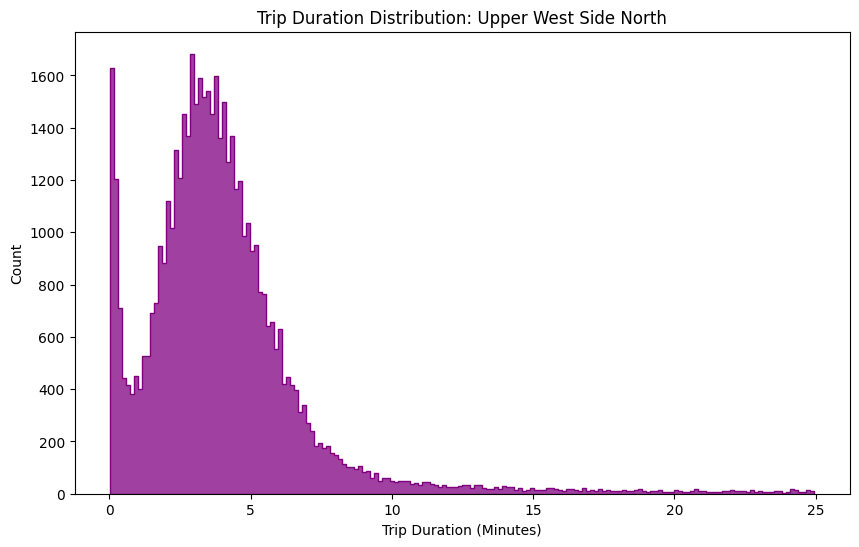

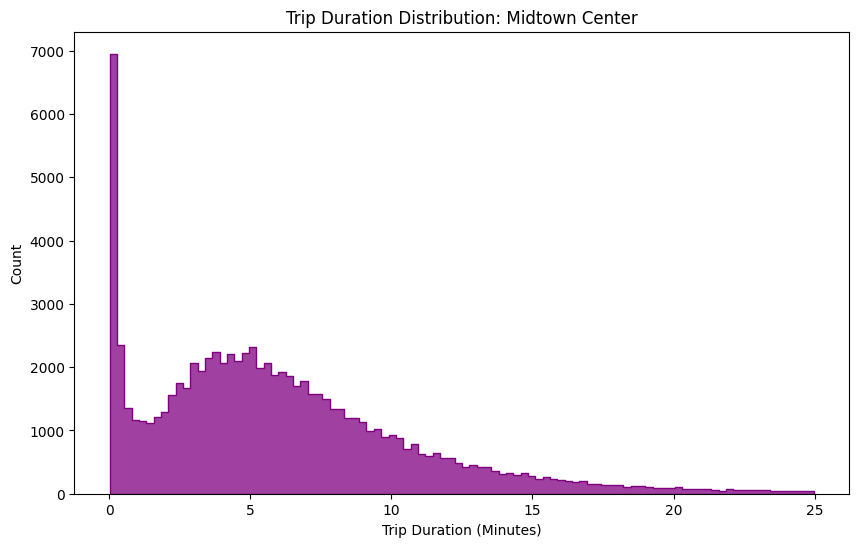

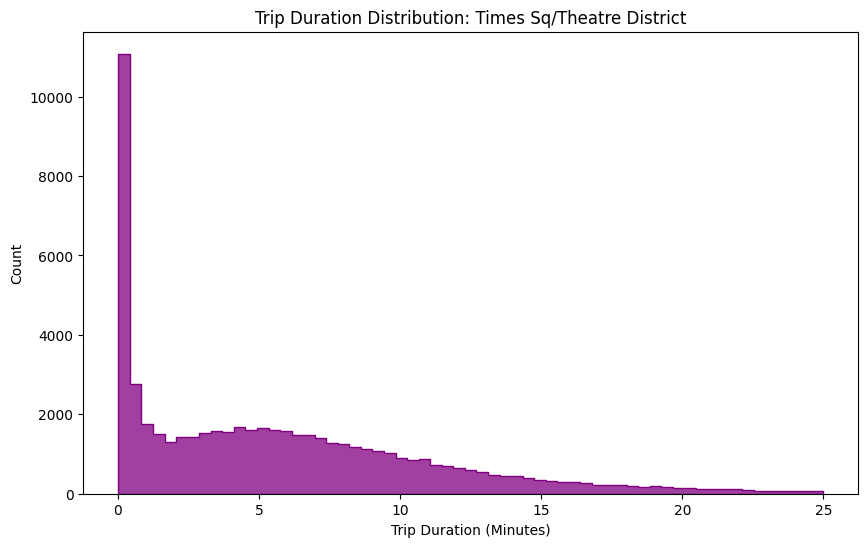

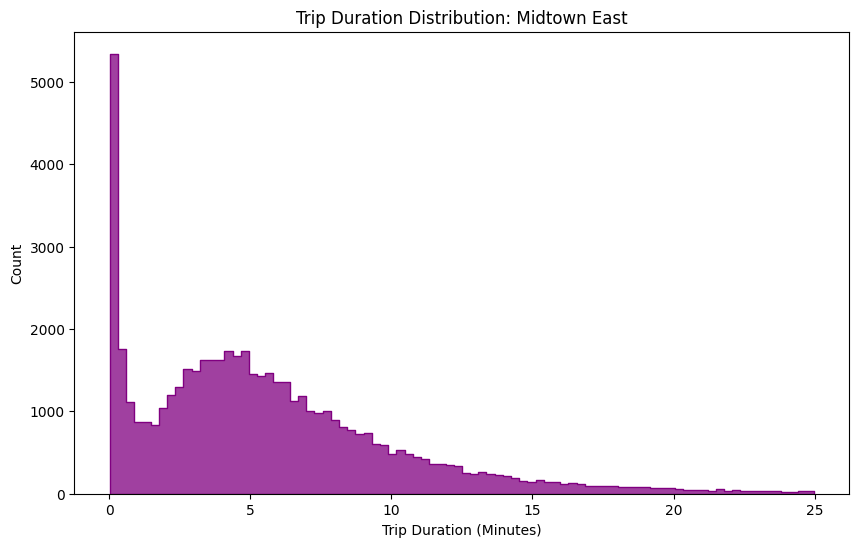

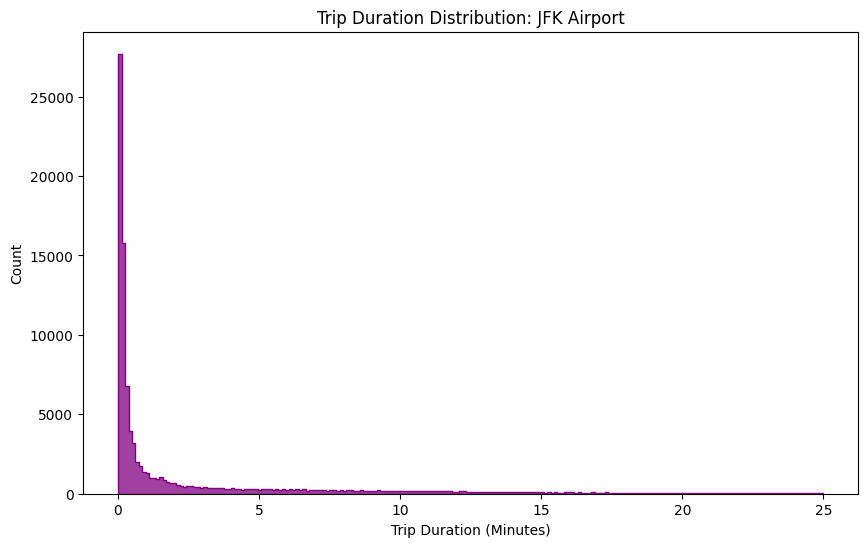

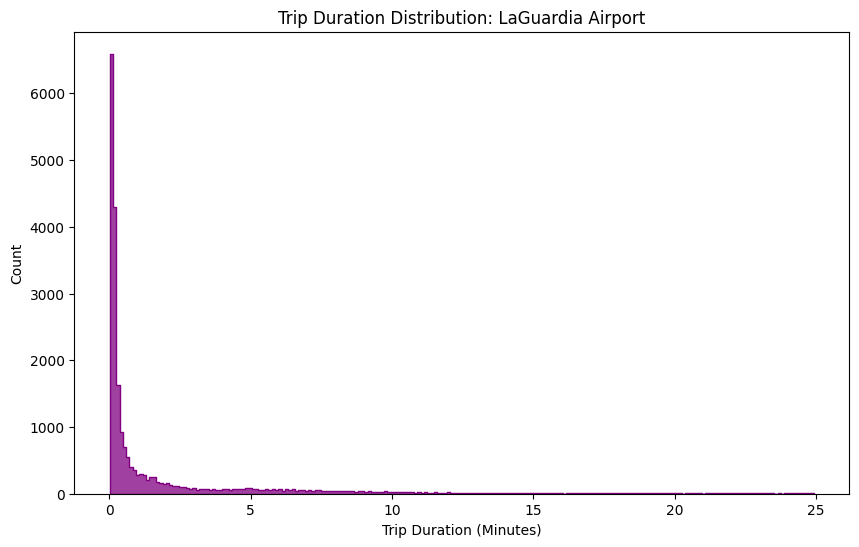

In [41]:
trip_duration_same_zone("Upper East Side South")
trip_duration_same_zone("Upper West Side North")
trip_duration_same_zone("Midtown Center")
trip_duration_same_zone("Times Sq/Theatre District")
trip_duration_same_zone("Midtown East")

trip_duration_same_zone("JFK Airport")
trip_duration_same_zone("LaGuardia Airport")

## 2. The predictive modeling pipeline

Having explored the dataset, we shall now shift our focus on creating a model that will allow us to predict how many pick-ups and drop-offs there will be at any given time at a given zone. This will consist of two independent regression models that will predict the respective count data. This is a big simplification, since a pick-up in a zone implies a drop-off at a different one. However, this approach is sufficient for the purpose of this exercise.

To evaluate our model, we will download the whole 2025 Yellow Taxi data and use it as test set. Note that at the time of writing this, the December 2025 data is not yet available.

We will start with a baseline model, which will only use the taxi zone and time as features. Then, we will provide the model more information, like weather, public holidays and other events, to see if we can improve its accuracy by some factor.

### 2.1 Baseline: Preprocessing and Feature Engineering

Recall that we still have to impute the missing data observed in the last section; however, we will restrict our predictive features to be only the taxi zones and temporal features generated from the respective timestamps.

In [42]:
rel.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'PUBorough',
 'PUZone',
 'DOLocationID',
 'DOBorough',
 'DOZone',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [43]:
pickup_columns = ["PUZone", "tpep_pickup_datetime"]
dropoff_columns = ["DOZone", "tpep_dropoff_datetime"]
cols = pickup_columns + dropoff_columns
cols

['PUZone', 'tpep_pickup_datetime', 'DOZone', 'tpep_dropoff_datetime']

Recall that out of all of these columns, the only ones containing NA values are `PUZone` and `DOZone`, corresponding to the label `'N/A'`. 

In [44]:
rel.query(
    "rel6",
    """
    SELECT COUNT(*)/(SELECT COUNT(*) FROM rel6)*100 AS NAPercent
    FROM rel6
    WHERE PUZone = 'N/A' OR DOZone = 'N/A'
    """,
)

┌────────────────────┐
│     NAPercent      │
│       double       │
├────────────────────┤
│ 0.5765912423013807 │
└────────────────────┘

These represent only a $0.58\%$ of the whole dataset, so where are safe by dropping them.

In [45]:
def generate_count_grid(rel: duckdb.DuckDBPyRelation, year: int):
    pickups_full = rel.query(
        "rel7",
        f"""
        WITH TimeGrid AS (
            SELECT unnest(generate_series(
                TIMESTAMP '{year}-01-01 00:00:00', 
                TIMESTAMP '{year}-12-31 23:00:00', 
                INTERVAL 1 HOUR
            )) AS GridTime
        ), ZoneGrid AS (
           SELECT unnest(generate_series(1, 265)) AS Zone
        ),  FullGrid AS (
            SELECT 
                t.GridTime,
                z.Zone
            FROM TimeGrid t 
            CROSS JOIN ZoneGrid z
        ), ActualCounts AS (
            SELECT 
                PULocationID,
                date_trunc('hour', tpep_pickup_datetime) AS Hour,
                COUNT(*) AS Trips
            FROM rel7
            WHERE PULocationID IS NOT NULL
            GROUP BY 1, 2
        ) SELECT 
            m.Zone,
            YEAR(m.GridTime) AS Year,
            MONTH(m.GridTime) AS Month,
            DAY(m.GridTime) AS Day,
            HOUR(m.GridTime) AS Hour,
            WEEKDAY(m.GridTime) AS Weekday,
            COALESCE(a.Trips, 0) AS Count
        FROM FullGrid m
        LEFT JOIN ActualCounts a 
            ON m.Zone = a.PULocationID 
            AND m.GridTime = a.Hour
        ORDER BY m.GridTime, m.Zone
        """,
    ).to_df()

    dropoffs_full = rel.query(
        "rel7",
        f"""
        WITH TimeGrid AS (
            SELECT unnest(generate_series(
                TIMESTAMP '{year}-01-01 00:00:00', 
                TIMESTAMP '{year}-12-31 23:00:00', 
                INTERVAL 1 HOUR
            )) AS GridTime
        ), ZoneGrid AS (
            SELECT unnest(generate_series(1, 265)) AS Zone
        ), FullGrid AS (
            SELECT t.GridTime, z.Zone
            FROM TimeGrid t CROSS JOIN ZoneGrid z
        ), ActualCounts AS (
            SELECT 
                DOLocationID,
                date_trunc('hour', tpep_dropoff_datetime) AS Hour,
                COUNT(*) AS Trips
            FROM rel7
            WHERE DOLocationID IS NOT NULL
            GROUP BY 1, 2
        )
        SELECT 
            m.Zone,
            YEAR(m.GridTime) AS Year,
            MONTH(m.GridTime) AS Month,
            DAY(m.GridTime) AS Day,
            HOUR(m.GridTime) AS Hour,
            WEEKDAY(m.GridTime) AS Weekday,
            COALESCE(a.Trips, 0) AS Count
        FROM FullGrid m
        LEFT JOIN ActualCounts a 
            ON m.Zone = a.DOLocationID 
            AND m.GridTime = a.Hour
        ORDER BY m.GridTime, m.Zone
        """,
    ).to_df()
    return pickups_full, dropoffs_full

In [46]:
pickups_train, dropoffs_train = generate_count_grid(rel, 2024)

In [47]:
def compute_cyclical_features(df):
    df = df.copy()
    
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)    
    return df

In [48]:
def model_pipeline() -> Pipeline:
    cyclical_features = FunctionTransformer(compute_cyclical_features)
    encoder_step = ColumnTransformer(
        transformers=[
            (
                "cat_encoder",
                OrdinalEncoder(),
                ["Zone"],
            )
        ],
        remainder="passthrough",
    )

    pipeline = Pipeline(
        [
            ("cyclical_features", cyclical_features),
            ("encoder", encoder_step.set_output(transform="pandas")),
            (
                "model",
                xgb.XGBRegressor(
                    objective='count:poisson',
                    eval_metric='poisson-nloglik',
                    n_estimators=1000,
                    learning_rate=0.1,
                    max_depth=6,
                    tree_method="hist",
                    random_state=1234,
                    n_jobs=-1,
                ),
            ),
        ]
    )
    return pipeline

In [49]:
pickups_train_sample = pickups_train#sample(n=100000, random_state=1234)
dropoffs_train_sample = dropoffs_train#sample(n=100000, random_state=1234)

pickups_model = model_pipeline().fit(
    pickups_train_sample[["Zone", "Month", "Day", "Hour", "Weekday"]], pickups_train_sample[["Count"]]
)
dropoffs_model = model_pipeline().fit(
    dropoffs_train_sample[["Zone", "Month", "Day", "Hour", "Weekday"]],
    dropoffs_train_sample[["Count"]],
)

In [ ]:
data_dir = Path("data/test")
if not data_dir.is_dir():
    data_dir.mkdir(parents=True, exist_ok=True)
if not any(data_dir.iterdir()):
    session: requests.Session = requests.session()
    for month in range(1, 12):
        print(f"Fetching data for month {month:02d}...")
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-{month:02d}.parquet"  # URL may change due to proxies and stuff. Last checked: 05/01
        res = session.get(url=url)
        res.raise_for_status()
        with open(f"data/test/data-{month:02d}.parquet", "wb") as file:
            file.write(res.content)
        print("\tDone!")
        time.sleep(5)  # Sleep because we are good samaritans

In [51]:
rels_test = [duckdb.read_parquet(f"data/test/data-{month:02d}.parquet") for month in range(1, 12)]
rel_test = reduce(lambda rel_1, rel_2: rel_1.union(rel_2), rels_test).query(
    "s",
    """
    SELECT
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        PULocationID,
        DOLocationID
    FROM s
    """
)

In [52]:
rel_test

┌──────────────────────┬───────────────────────┬──────────────┬──────────────┐
│ tpep_pickup_datetime │ tpep_dropoff_datetime │ PULocationID │ DOLocationID │
│      timestamp       │       timestamp       │    int32     │    int32     │
├──────────────────────┼───────────────────────┼──────────────┼──────────────┤
│ 2025-01-01 00:18:38  │ 2025-01-01 00:26:59   │          229 │          237 │
│ 2025-01-01 00:32:40  │ 2025-01-01 00:35:13   │          236 │          237 │
│ 2025-01-01 00:44:04  │ 2025-01-01 00:46:01   │          141 │          141 │
│ 2025-01-01 00:14:27  │ 2025-01-01 00:20:01   │          244 │          244 │
│ 2025-01-01 00:21:34  │ 2025-01-01 00:25:06   │          244 │          116 │
│ 2025-01-01 00:48:24  │ 2025-01-01 01:08:26   │          239 │           68 │
│ 2025-01-01 00:14:47  │ 2025-01-01 00:16:15   │          170 │          170 │
│ 2025-01-01 00:39:27  │ 2025-01-01 00:51:51   │          234 │          148 │
│ 2025-01-01 00:53:43  │ 2025-01-01 01:13:23   │    

In [53]:
pickups_test, dropoffs_test = generate_count_grid(rel_test, 2025)

In [54]:
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error:" \
    f"""
    {mean_absolute_error(
        pickups_test[["Count"]],
        pickups_model.predict(
            pickups_test[["Zone", "Month", "Day", "Hour", "Weekday"]]
        ),
    )}"""
)
print("R^2 Score:" \
    f"""
    {r2_score(
        pickups_test[["Count"]],
        pickups_model.predict(
            pickups_test[["Zone", "Month", "Day", "Hour", "Weekday"]]
        ),
    )}"""
)

Mean Absolute Error:
    6.867040634155273
R^2 Score:
    0.8315590620040894


In [55]:

print("Mean Absolute Error:" \
    f"""
    {mean_absolute_error(
        dropoffs_test[["Count"]],
        dropoffs_model.predict(
            dropoffs_test[["Zone", "Month", "Day", "Hour", "Weekday"]]
        ),
    )}"""
)
print("R^2 Score:" \
    f"""
    {r2_score(
        dropoffs_test[["Count"]],
        dropoffs_model.predict(
            dropoffs_test[["Zone", "Month", "Day", "Hour", "Weekday"]]
        ),
    )}"""
)

Mean Absolute Error:
    6.668201923370361
R^2 Score:
    0.8316999077796936


### 2.2 Introducing more information

The baseline model in itself is not enough: indeed, it contains the most significant features to predict our target taxi dynamics; however, they do not contain any information regarding the environment where these come into play, and the possible disruptions it can provoke. Hence, we wish to include more information to the XGBoost regressor model.

We have curated the following extra datasets, which we will incorporate in our hourly pick-up/drop-off count data as extra features:

1. **Weather Dataset**: We have downloaded the full historic of weather data of NYC 2024 (train) and 2025 (test), including information regarding temperature, precipitation, wind, etc. _Source: https://open-meteo.com/_
2. **Public Events**: An interesting experiment, following the suggestion made in the assgiment statement, would be to consider relevant events in NYC during the year which could in turn disrupt the usual taxi dynamics. To do this, we have asked Google Gemini to research on the web for significant events and generate a JSON file with their approximate timestamps and affected taxi zones.
3. **Holidays**: We introduce the `holidays` library, which can easily provide us with the holidays for the state of New York, which we can incoporate as another feature.



#### 2.2.1 Feature engineering

We use DuckDB's extensive connector catalog to load the data and use its SQL interface to easily generate our datasets.

In [56]:
weather_train_rel = duckdb.read_csv("data/weather-2024.csv")
weather_test_rel = duckdb.read_csv("data/weather-2025.csv")
def generate_weather_features(raw_weather_data: duckdb.DuckDBPyRelation):
    return raw_weather_data.query(
        "u",
        """
        SELECT
            MONTH(u.time) as Month,
            DAY(u.time) as Day,
            HOUR(u.time) as Hour,
            "temperature_2m (°C)" AS Temperature,
            "relative_humidity_2m (%)" AS RelativeHumidity,
            "rain (mm)" AS Rain,
            "snowfall (cm)" AS Snowfall,
            "precipitation (mm)" AS Precipitation,
            "snow_depth (m)" AS SnowDepth,
            "wind_speed_10m (km/h)" AS WindSpeed10,
            "wind_speed_100m (km/h)" AS WindSpeed100,
            "wind_direction_10m (°)" AS WindDir10,
            "wind_direction_100m (°)" AS WindDir100 
        FROM u
        """
    )
weather_train_df = generate_weather_features(weather_train_rel).to_df()
weather_test_df = generate_weather_features(weather_test_rel).to_df()

In [57]:
event_train_rel = duckdb.read_json("data/events-2024.json")
event_test_rel = duckdb.read_json("data/events-2025.json")

def generate_event_features(raw_event_data: duckdb.DuckDBPyRelation):
    return raw_event_data.query(
        "u",
        """
        SELECT
            name AS EventName,
            MONTH(u.date) as Month,
            DAY(u.date) as Day,
            unnest(affected_tlc_zones) As Zone
        FROM u
        """,
        )

events_train_df = generate_event_features(event_train_rel).to_df()
events_test_df = generate_event_features(event_test_rel).to_df()

In [58]:
import holidays

def get_holiday_features(year: int):
    ny_holidays = holidays.US(subdiv='NY', years=[year])
    holidays_rel = duckdb.from_df(pd.DataFrame({'Name':ny_holidays.values(), 'Date': ny_holidays.keys()}))
    return holidays_rel.query(
        "u",
        """
        SELECT
            Name AS EventName,
            MONTH(u.Date) as Month,
            DAY(u.Date) as Day
        FROM u
        """
    )
holidays_train_df = get_holiday_features(2024).to_df()
holidays_test_df = get_holiday_features(2025).to_df()

#### 2.2.2 Building training and test dataset

In [59]:
def generate_extra_features(df, holidays_df, events_df, weather_df):
    df = df.merge(right=holidays_df, on=["Month", "Day"], how="left")
    df['IsHoliday'] = (~df['EventName'].isna()).astype(int)
    df = df.drop(columns=['EventName'])

    df = df.merge(right=events_df, on=["Month", "Day", "Zone"], how="left")
    df['HasEvent'] = (~df['EventName'].isna()).astype(int)
    df = df.drop(columns=['EventName'])

    df = df.merge(right=weather_df, on=["Month", "Day", "Hour"], how="inner")
    return df

#### 2.2.3 Model pipeline

We rebuild our model pipeline to include the new features. We shall now scale numerical variables, and incorporate wind direction as a cyclical feature aswell.

In [60]:
from sklearn.preprocessing import StandardScaler


def compute_cyclical_features_extra(df):
    df = df.copy()

    df["hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df["Weekday"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["Weekday"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    df["wind_dir_10_sin"] = np.sin(2 * np.pi * df["WindDir10"] / 360)
    df["wind_dir_10_cos"] = np.cos(2 * np.pi * df["WindDir10"] / 360)

    df["wind_dir_100_sin"] = np.sin(2 * np.pi * df["WindDir100"] / 360)
    df["wind_dir_100_cos"] = np.cos(2 * np.pi * df["WindDir100"] / 360)
    return df


def model_extra_pipeline() -> Pipeline:
    numeric_features = [
        "Temperature",
        "RelativeHumidity",
        "Rain",
        "Snowfall",
        "Precipitation",
        "SnowDepth",
        "WindSpeed10",
        "WindSpeed100",
    ]

    categorical_features = ["Zone"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), numeric_features),
            (
                "cat_encoder",
                OrdinalEncoder(),
                categorical_features,
            ),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

    pipeline = Pipeline(
        [
            (
                "feature_engineering",
                FunctionTransformer(compute_cyclical_features_extra, validate=False),
            ),
            ("preprocessor", preprocessor.set_output(transform="pandas")),
            (
                "model",
                xgb.XGBRegressor(
                    objective="count:poisson",
                    eval_metric="poisson-nloglik",
                    n_estimators=1000,
                    learning_rate=0.1,
                    max_depth=6,
                    tree_method="hist",
                    random_state=1234,
                    n_jobs=-1,
                ),
            ),
        ]
    )
    return pipeline

In [61]:
pickups_extra_train = generate_extra_features(
    pickups_train, holidays_train_df, events_train_df, weather_train_df
)
pickups_extra_test = generate_extra_features(
    pickups_test, holidays_test_df, events_test_df, weather_test_df
)

dropoffs_extra_train = generate_extra_features(
    dropoffs_train, holidays_train_df, events_train_df, weather_train_df
)
dropoffs_extra_test = generate_extra_features(
    dropoffs_test, holidays_test_df, events_test_df, weather_test_df
)

In [62]:
pickups_extra_model = model_extra_pipeline().fit(
    pickups_extra_train.drop(columns=['Count']), pickups_extra_train[["Count"]]
)
dropoffs_extra_model = model_extra_pipeline().fit(
    dropoffs_extra_train.drop(columns=['Count']), dropoffs_extra_train[["Count"]]
)

In [63]:
print("Mean Absolute Error:" \
    f"""
    {mean_absolute_error(
        pickups_extra_test[["Count"]],
        pickups_extra_model.predict(
            pickups_extra_test.drop(columns=['Count'])
        ),
    )}"""
)
print("R^2 Score:" \
    f"""
    {r2_score(
        pickups_extra_test[["Count"]],
        pickups_extra_model.predict(
            pickups_extra_test.drop(columns=['Count'])
        ),
    )}"""
)

Mean Absolute Error:
    6.996358394622803
R^2 Score:
    0.8278414011001587


In [64]:
print("Mean Absolute Error:" \
    f"""
    {mean_absolute_error(
        dropoffs_extra_test[["Count"]],
        dropoffs_extra_model.predict(
            dropoffs_extra_test.drop(columns=['Count'])
        ),
    )}"""
)
print("R^2 Score:" \
    f"""
    {r2_score(
        dropoffs_extra_test[["Count"]],
        dropoffs_extra_model.predict(
            dropoffs_extra_test.drop(columns=['Count'])
        ),
    )}"""
)

Mean Absolute Error:
    6.81822395324707
R^2 Score:
    0.8274374008178711
